In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass  #this might not be needed anymore
from os import environ, name
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)

%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

### Loading the data

In [8]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
dfx = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
dfx["student"] = dfx["student"].astype('category')
dfx["Family"]=dfx["Family"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

####

# df = pd.read_csv(get_path() + 'MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized_DONT_TOUCH_ME.txt')
# df["student"] = df["student"].astype('category')
# df["Family"]=df["Family"].str.capitalize()

# def remodel_families(row):
#     if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
#         if row["Outcome"] != "None":
#             return "ConstructWithFeedback"
#         else:
#             return "Construct"
#     else:
#         return row["Family"]
    
# def remodel_families2(row):
#     if row["Family"] == "ConstructWithFeedback" or row["Family"] == "Organize":
#         return "Construct"
#     else:
#         return row["Family"]

# df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)
# df2 = df.copy()
# df2['Family'] = df2.apply (lambda row: remodel_families2 (row),axis=1)

In [9]:
def get_blocks_withTime(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        if action[0] in ignore:
            return ''
        elif action == 'Reset':
            return 'X'
        elif action == 'ConstructWithFeedback':
            return 'F'
        else: 
            return action[0]
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'(.)\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator 
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'(.)\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
        else:
            blocks[student] += block
    return blocks, time_coord

In [10]:
def plot_barGraph(df,ACTIVITY, studentID, pltFamilies):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coord = get_blocks_withTime(df[df.Activity==ACTIVITY],{studentID},add_spaces=True, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    #need this to convert desired action families back to letter code
    def convert(action,ignore):
            if action[0] in ignore:
                return ''
            elif action == 'Reset':
                return 'X'
            elif action == 'ConstructWithFeedback':
                return 'F'
            else: 
                return action[0]
    nn=1
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    for action in pltFamilies: 
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        out = [(x,y) for x,y in zip(blocks[studentID].split(),time_coord) if any(convert(action,[])==z for z in x)]
        junk, time_coord_filtered = map(list,zip(*out))  
        ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
        nn+=1
    
    ax.set_ylim(5, len(pltFamilies)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(pltFamilies)*10+15,10))
    ax.set_yticklabels(pltFamilies, fontsize=25)
    ax.grid(True)
    
    plt.show()


## Using new categories
Here are the new "family" action categories.

In [11]:
set(dfx['Family'])

{'Construct',
 'Interface',
 'Pause',
 'Test_basic',
 'Test_complex',
 'Test_other',
 'Test_simple'}

In [12]:
dfx.head()

,Activity,student,Time Stamp,Family,Family_tool,Family_default,Family_both,Action,Component,Outcome,#circuits,#circuits_w_battery,#loops,#components,#battery,#circuitSwitch,#grabBagResistor,#lightBulb,#resistor,#seriesAmmeter,current_is_circuit,current_#loops,current_#components,current_#battery,current_#circuitSwitch,current_#grabBagResistor,current_#lightBulb,current_#resistor,current_#seriesAmmeter,non_default_resistor_values
0,a2,10009106,1363981168331,Construct,Construct,Construct,Construct,add,wire,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,a2,10009106,1363981175425,Construct,Construct,Construct,Construct,add,battery,None,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,a2,10009106,1363981178425,Construct,Construct,Construct,Construct,add,resistor,None,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,a2,10009106,1363981178426,Pause,pause,pause,pause,pause,pause,pause,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,a2,10009106,1363981193503,Interface,Interface,Interface,Interface,view,zoom,None,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
converter =  {"Construct" : "C",
"Interface" : "I",
"Pause" : "P",
"Test_basic" : "Tb",
"Test_basic_default" : "Tbd",
"Test_basic_nonContactAmmeter" : "Tba",
"Test_basic_nonContactAmmeter_default" : "Tbad",
"Test_basic_nonContactAmmeter_not" : "Tban",
"Test_basic_not" : "Tbn",
"Test_basic_voltmeter" : "Tbv",
"Test_basic_voltmeter_default" : "Tbvd",
"Test_basic_voltmeter_not" : "Tbvn",
"Test_complex" : "Tc",
"Test_complex_default" : "Tcd",
"Test_complex_nonContactAmmeter" : "Tca",
"Test_complex_nonContactAmmeter_default" : "Tcad",
"Test_complex_nonContactAmmeter_not" : "Tcan",
"Test_complex_not" : "Tcn",
"Test_complex_seriesAmmeter" : "Tc",
"Test_complex_seriesAmmeter_default" : "Tcd",
"Test_complex_seriesAmmeter_not" : "Tcn",
"Test_complex_voltmeter" : "Tcv",
"Test_complex_voltmeter_default" : "Tcvd",
"Test_complex_voltmeter_not" : "Tcvn",
"Test_other" : "To",
"Test_other_default" : "Tod",
"Test_other_nonContactAmmeter" : "Toa",
"Test_other_nonContactAmmeter_default" : "Toad",
"Test_other_nonContactAmmeter_not" : "Toan",
"Test_other_not" : "Ton",
"Test_other_voltmeter_not" : "Tovn",
"Test_other_voltmeter" : "Tov",
"Test_other_voltmeter_default" : "Tovd",
"Test_simple" : "Ts",
"Test_simple_default" : "Tsd",
"Test_simple_nonContactAmmeter" : "Tsa",
"Test_simple_nonContactAmmeter_default" : "Tsad",
"Test_simple_nonContactAmmeter_not" : "Tsan",
"Test_simple_not" : "Tsn",
"Test_simple_voltmeter" : "Tsv",
"Test_simple_voltmeter_default" : "Tsvd",
"Test_simple_voltmeter_not" : "Tsvn",
    }

color_pos =  {'Construct':('#31a354',1),
    'Pause':('#969696',2),
    'Test_basic': ('#fb6a4a',3),
    'Test_basic_not_noncontactammeter': ('#fb6a4a',3),
    'Test_basic_not_voltmeter': ('#6baed6',3),
    'Test_basic_default_noncontactammeter': ('#fcae91',3),
    'Test_basic_default_voltmeter': ('#bdd7e7',3),
    'Test_simple': ('#a50f15',4),
    'Test_simple_not_noncontactammeter': ('#a50f15',4),
    'Test_simple_default_noncontactammeter': ('#de2d26',4),
    'Test_simple_not_voltmeter': ('#08519c',4),
    'Test_simple_default_voltmeter': ('#3182bd',4),
    'Test_complex': ('#4a1486',5),
    'Test_complex_not': ('#4a1486',5),
    'Test_complex_default': ('#9e9ac8',5),
    'Test_other':('#c51b8a',6),
    'Test_other_not':('#c51b8a',6),
    'Test_other_default':('#f768a1',6),
    }


# axis_labels =  ['Construct',
#     'Pause',
#     'Test_basic',
#     'Test_simple',
#     'Test_complex',
#     'Test_other',
#     ]

axis_labels =  ['Construct',
    'Pause',
    'Test_basic',
    'Test_simple',
    'Test_complex',
    ]

# pltFamilies_new=converter.keys()
# pltFamilies_new.sort()
# pltFamilies_new.remove('Interface')

def get_blocks_withTime_new(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        return converter[action]
    
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}

    time_coords = {student:[] for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,3})\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            #for matches of action denoted by more than 1 letter, need to correct the span
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            previous_start = ind[1]
            #print match.group(), ind
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,3})\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
            time_coords[student] = time_coord
        else:
            blocks[student] += block
            time_coords[student] = time_coord
    return blocks, time_coords
 

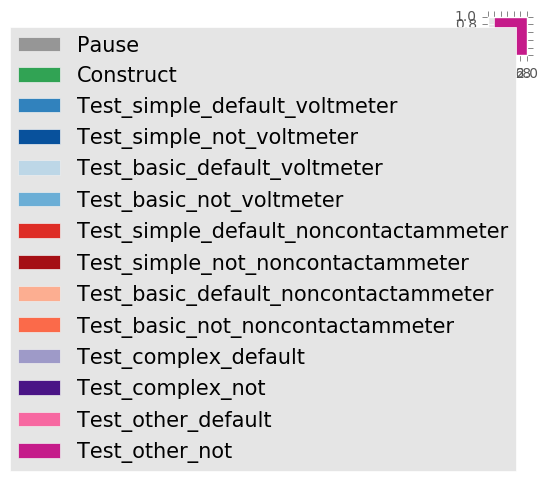

In [22]:
def plot_barGraph_new(df,ACTIVITY, studentID, pltFamilies,axis_labels):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coords = get_blocks_withTime_new(df[df.Activity==ACTIVITY],{studentID},add_spaces=False, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    #need this to convert desired action families back to letter code

    def convert(action,ignore):
        return converter[action]
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,3})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]
    time_coord = time_coords[studentID]
    for action in pltFamilies: 
        nn = color_pos[action][1]
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        #print action
        #print (blocks[studentID])
        #print len(splitblocks), len(time_coord)
        if convert(action,[]) in splitblocks:
#             print convert(action,[])
#             print sum([1 for s in splitblocks if s ==convert(action,()) ])
            #out = [(x,y) for x,y in zip(splitblocks,time_coord) if any(convert(action,[]) == z for z in x)]
            out = [(x,y) for x,y in zip(splitblocks,time_coord) if convert(action,[]) == x]
            try:
                junk, time_coord_filtered = map(list,zip(*out))  
#                 ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
                ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=color_pos[action][0])
            except:
                print 'failed', action,convert(action,[])
#                 for x,y in zip(splitblocks,time_coord):
#                     print convert(action,[]), x,y, convert(action,[]) == x
                pass
    ax.set_ylim(5, len(axis_labels)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)
    return None

fig = plt.figure(figsize=(0.5,0.5))
ax = plt.subplot()
#Create custom artists
Artists = []
labels_ordered  = ['Pause', 'Construct', 'Test_simple_default_voltmeter', 'Test_simple_not_voltmeter', 'Test_basic_default_voltmeter', 'Test_basic_not_voltmeter','Test_simple_default_noncontactammeter', 'Test_simple_not_noncontactammeter', 'Test_basic_default_noncontactammeter', 'Test_basic_not_noncontactammeter','Test_complex_default', 'Test_complex_not', 'Test_other_default', 'Test_other_not']
for key in labels_ordered:
    color  = color_pos[key][0]
    Artists.append(plt.bar(1,1,1, color=color))
ax.legend(Artists,[label for label in labels_ordered], prop={'size':15})
plt.show()

In [23]:
df_scores[df_scores["student"]==94792123]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
94,March,scaff,2,2,0,0,1,1,1,2,1,0.5,0.58,0.59,0.58,-0.16,0.19,0.58,0.08,2.78,2.67,2.56,4.0,2.5,knowledge,scaffolded_knowledge,94792123,-1801677759


### Color scheme
blue = voltmeter

red = ammeter

purple = either

pink = Test other

darker hues are "default" values, lighter hues are non default.

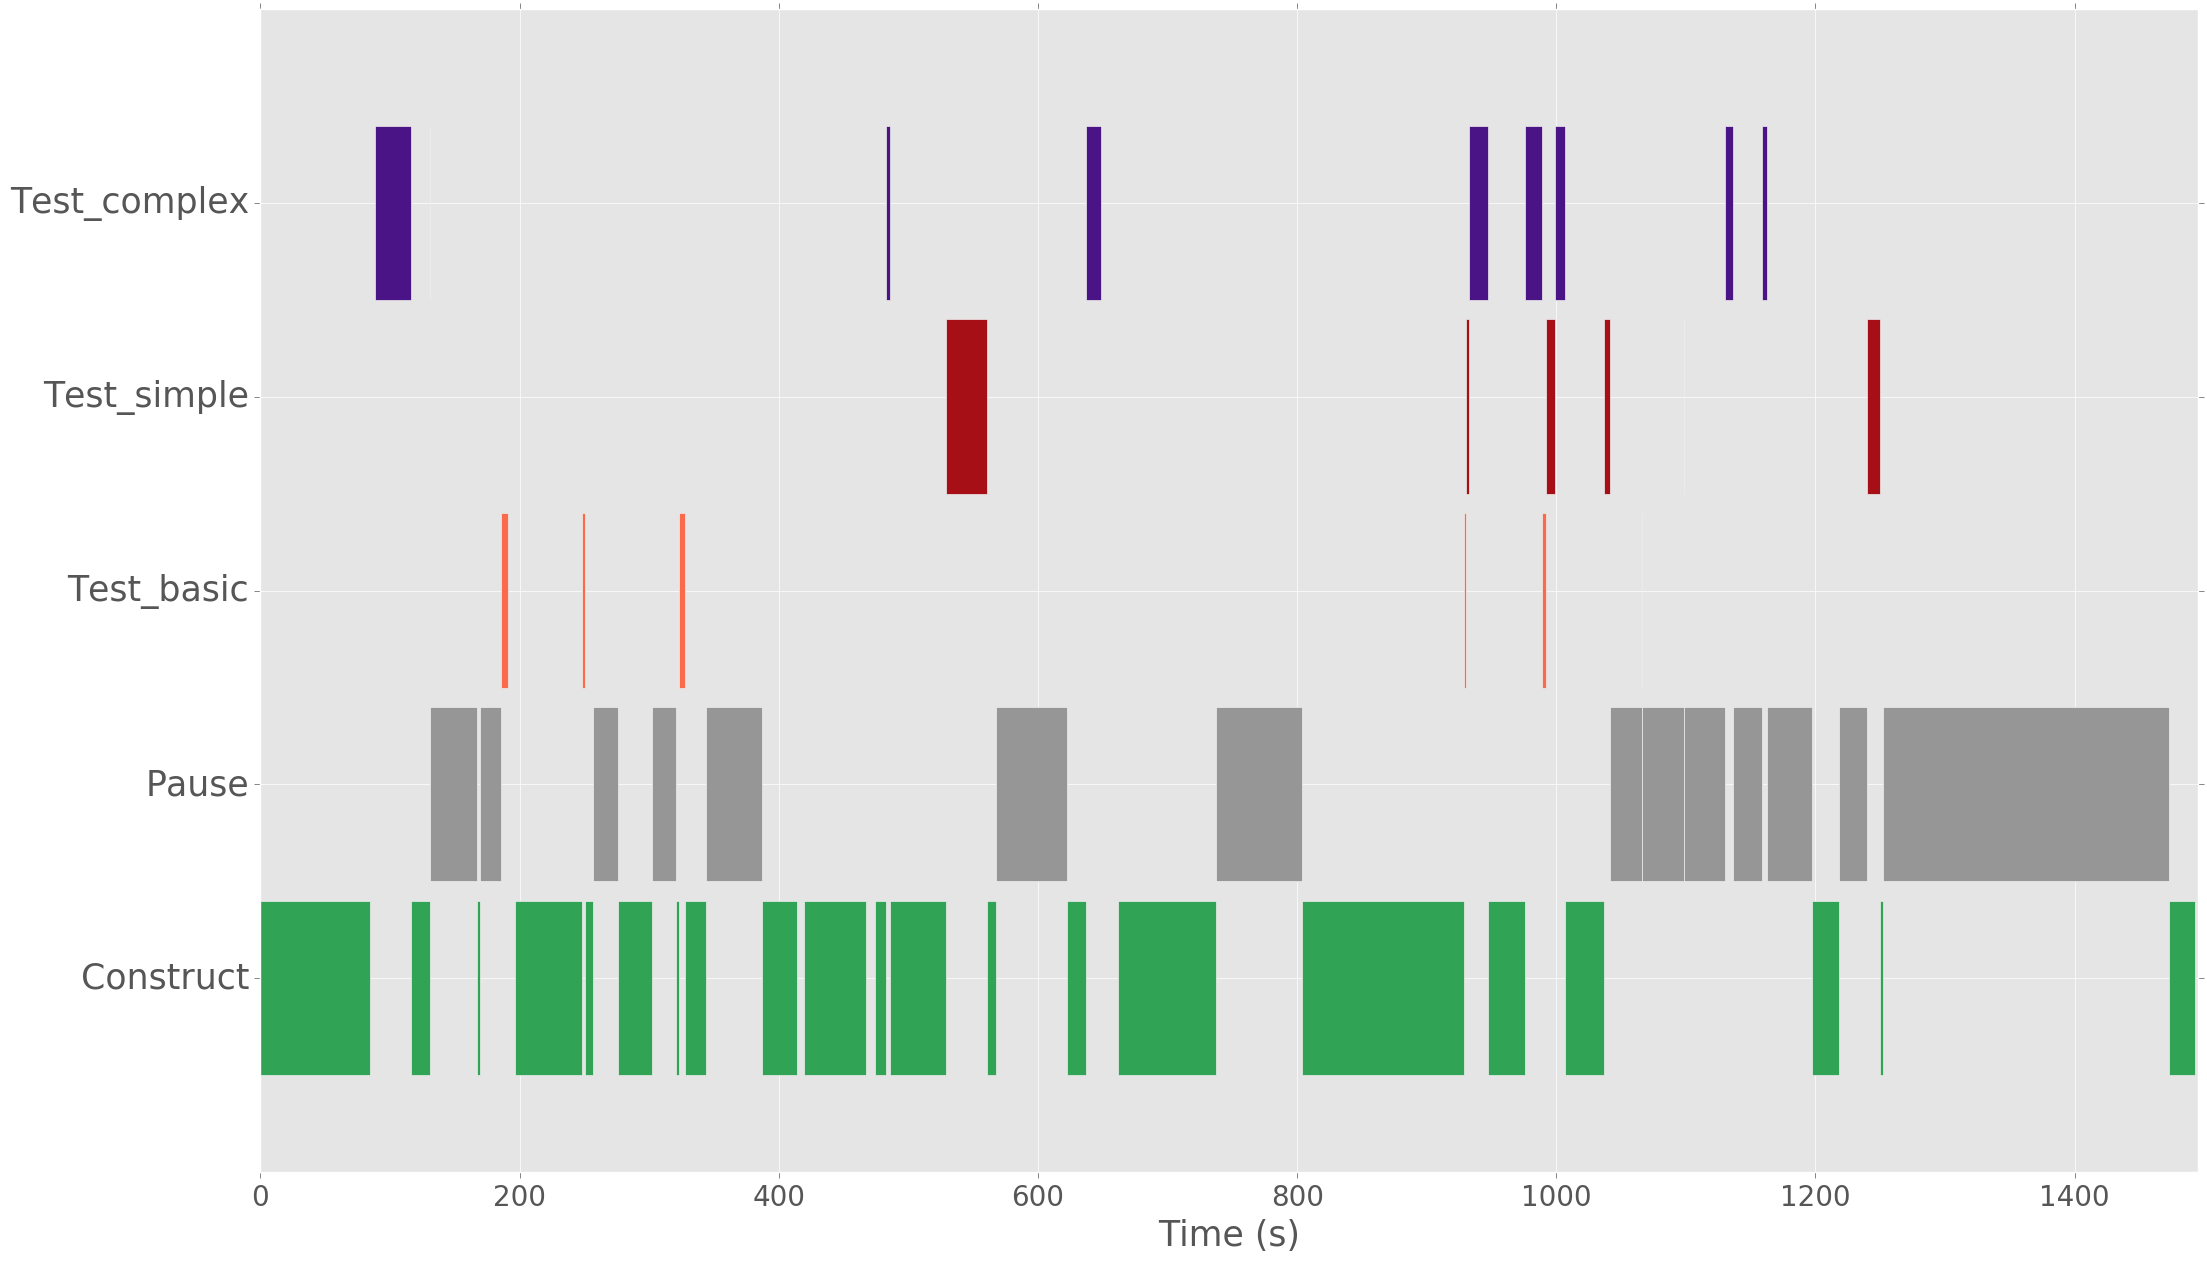

In [24]:
plot_barGraph_new(dfx,'a2', 94792123, axis_labels, axis_labels) 

In [25]:
###plot_barGraph_new(dfx,'a2', 94792123, pltFamilies_new, axis_labels) 

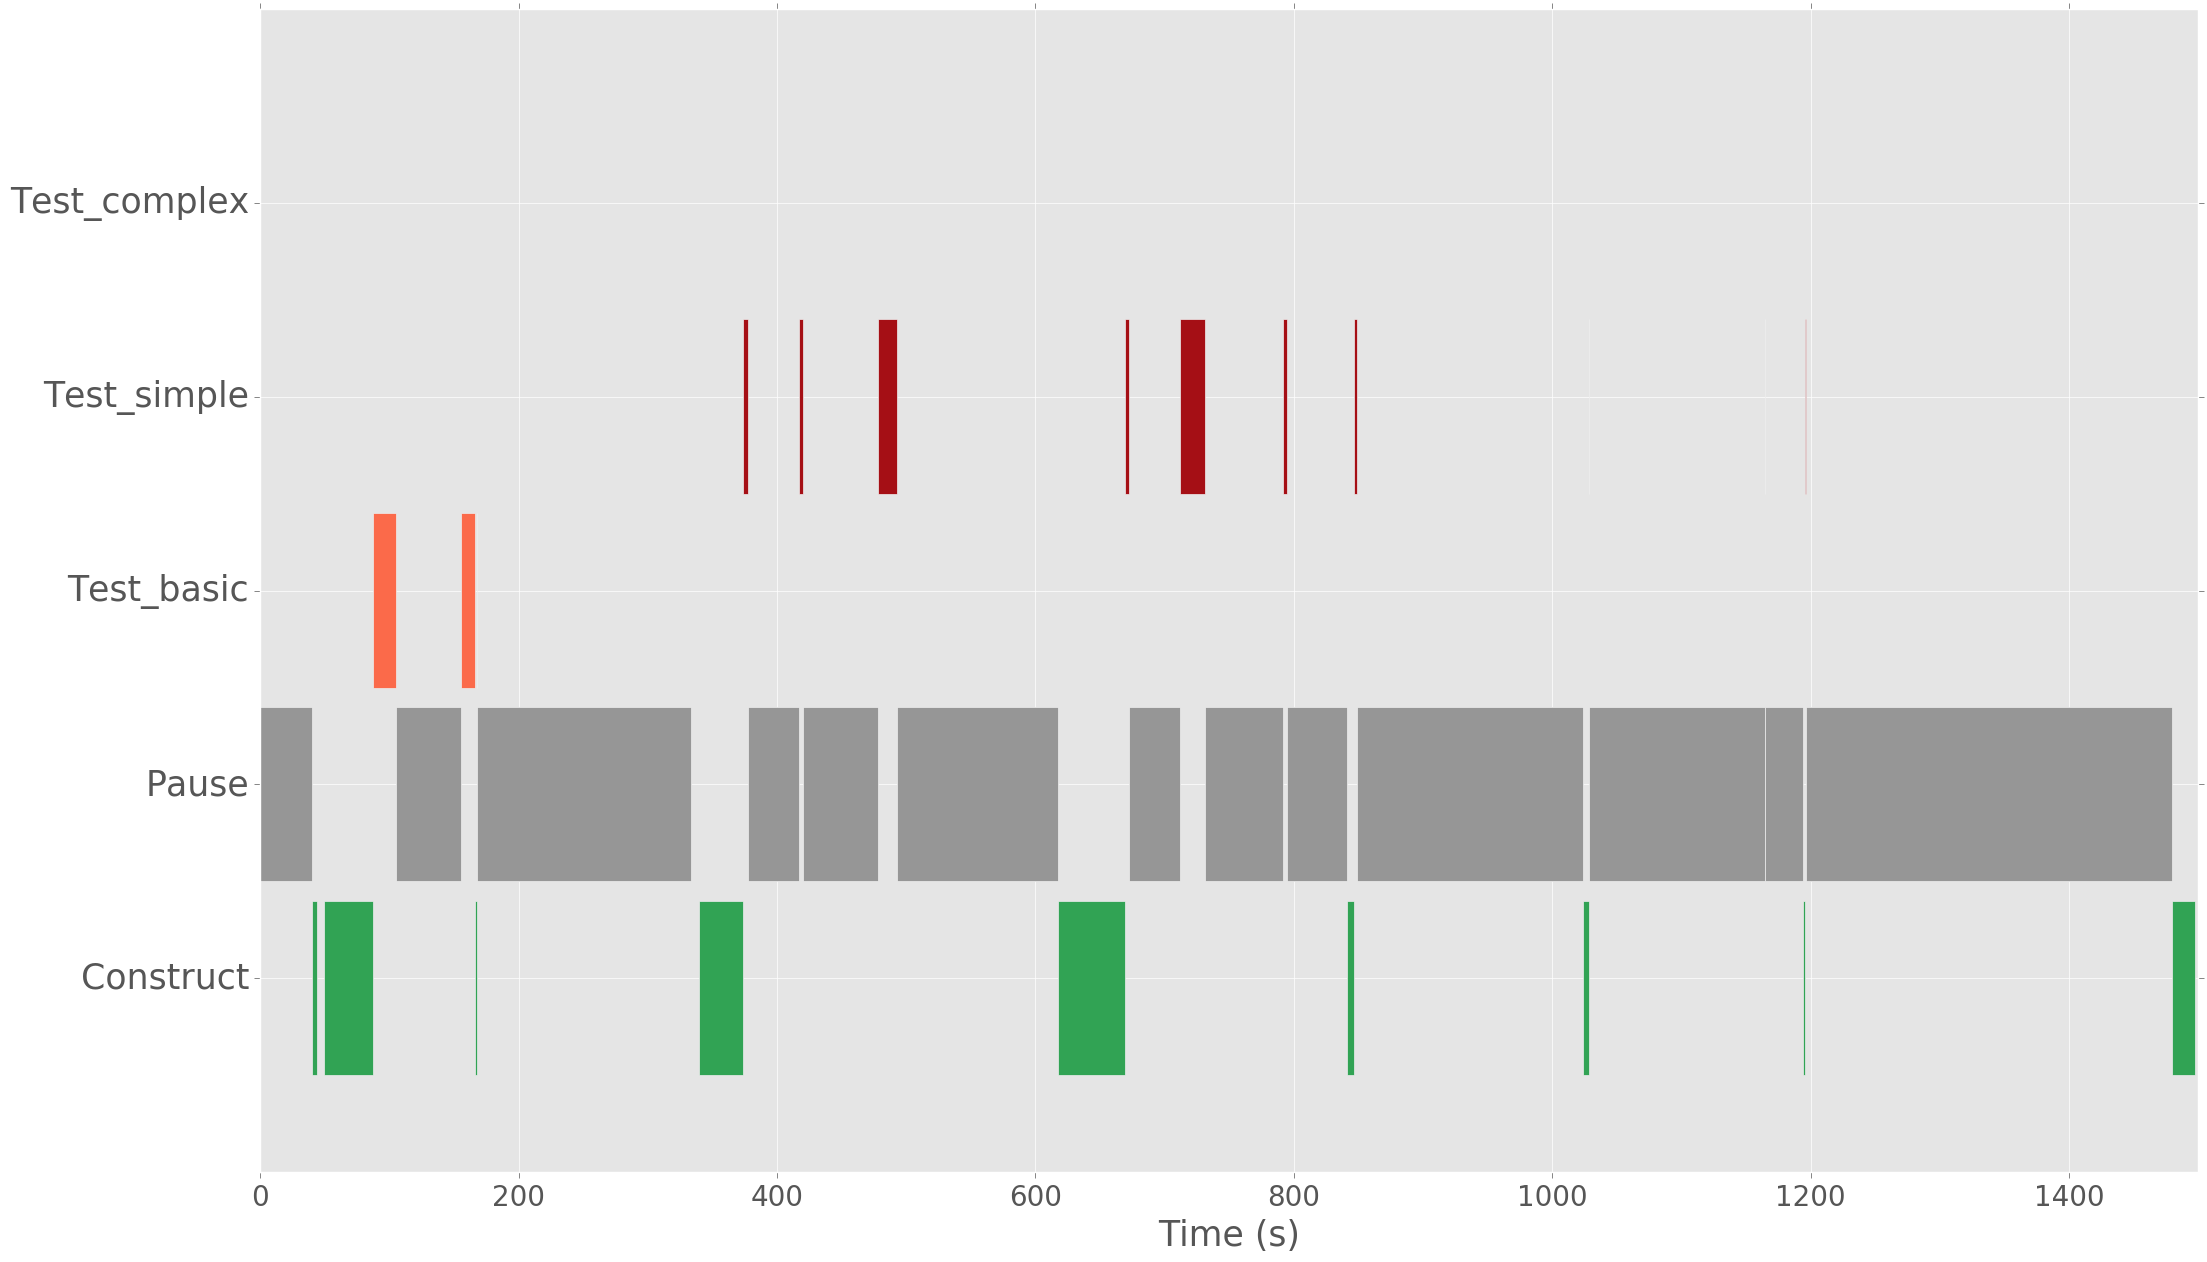

In [27]:
plot_barGraph_new(dfx,'a2', 8580120, axis_labels, axis_labels) #high high z-scores

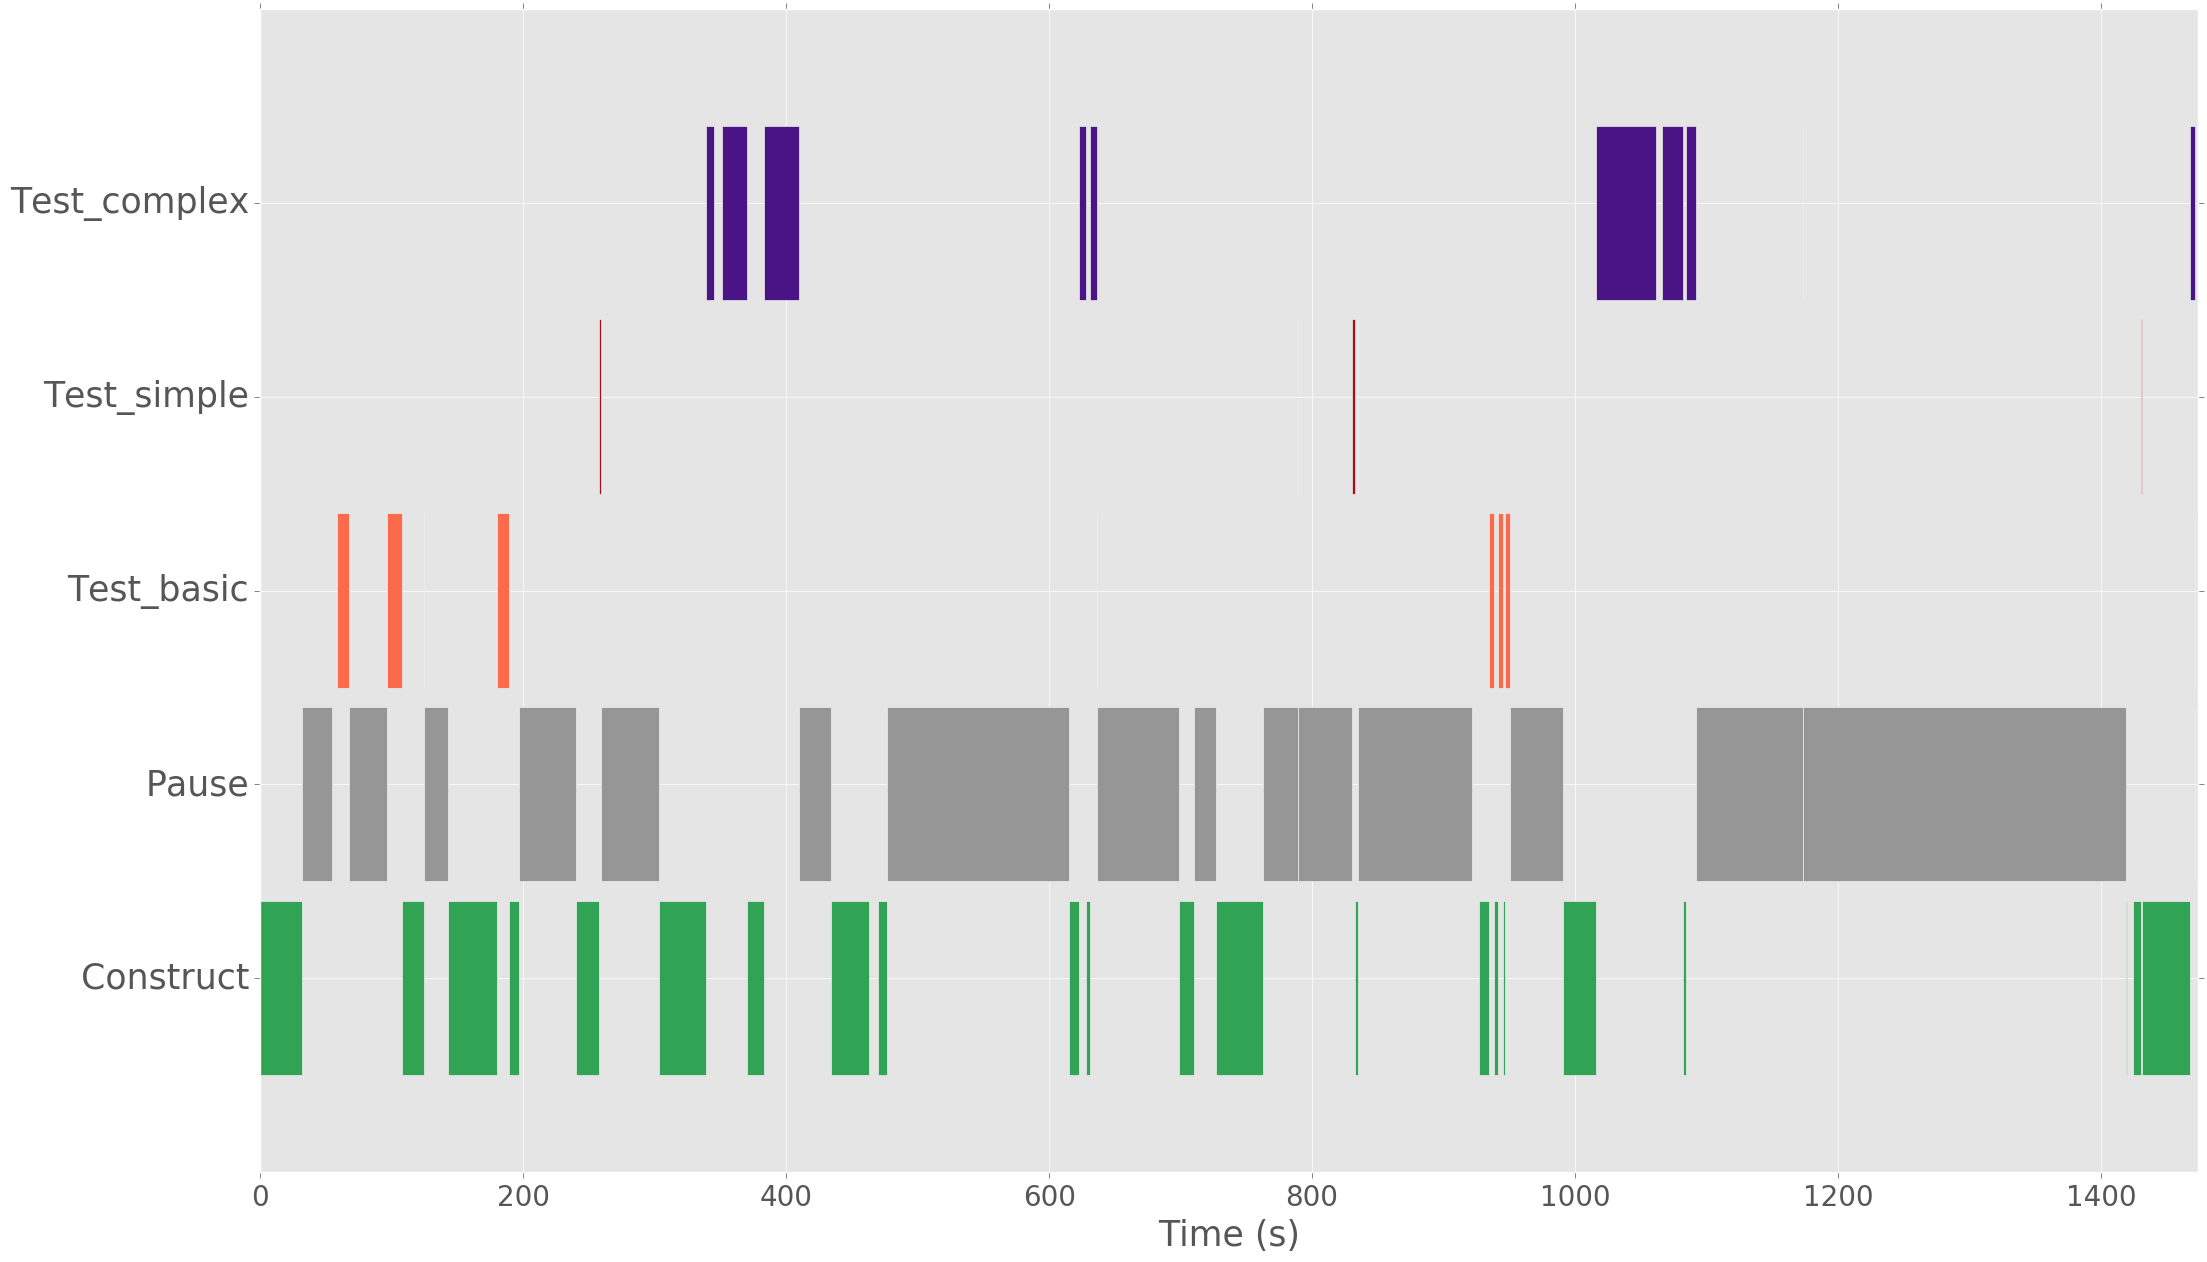

In [30]:
plot_barGraph_new(dfx,'a2', 18838125, axis_labels, axis_labels) #high high z-scores

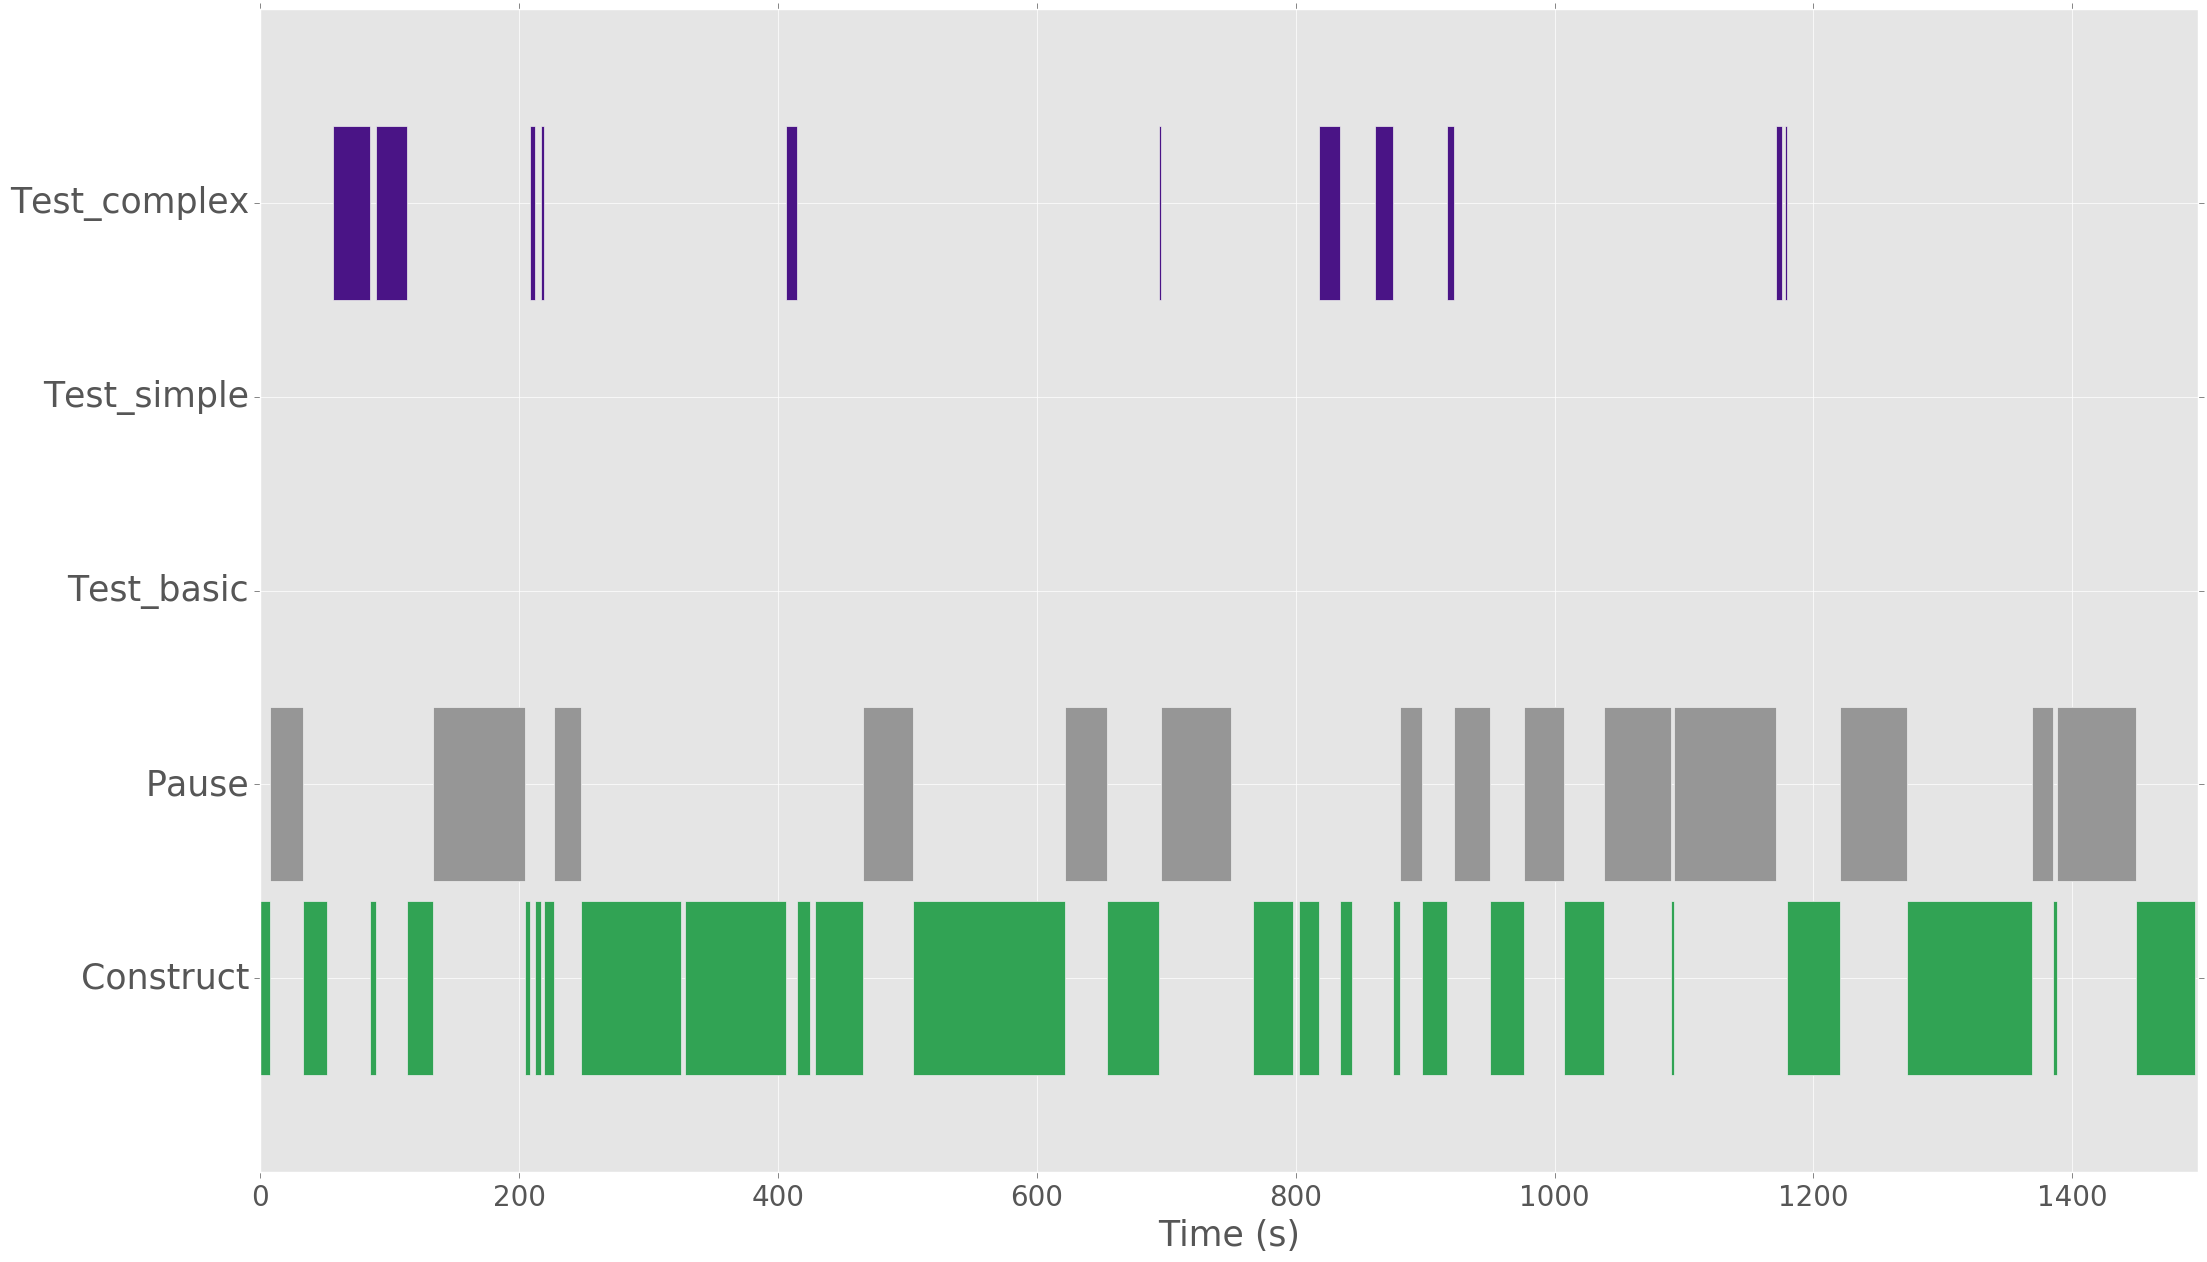

In [29]:
plot_barGraph_new(dfx,'a2', 8889108, axis_labels, axis_labels) #low low z-scores

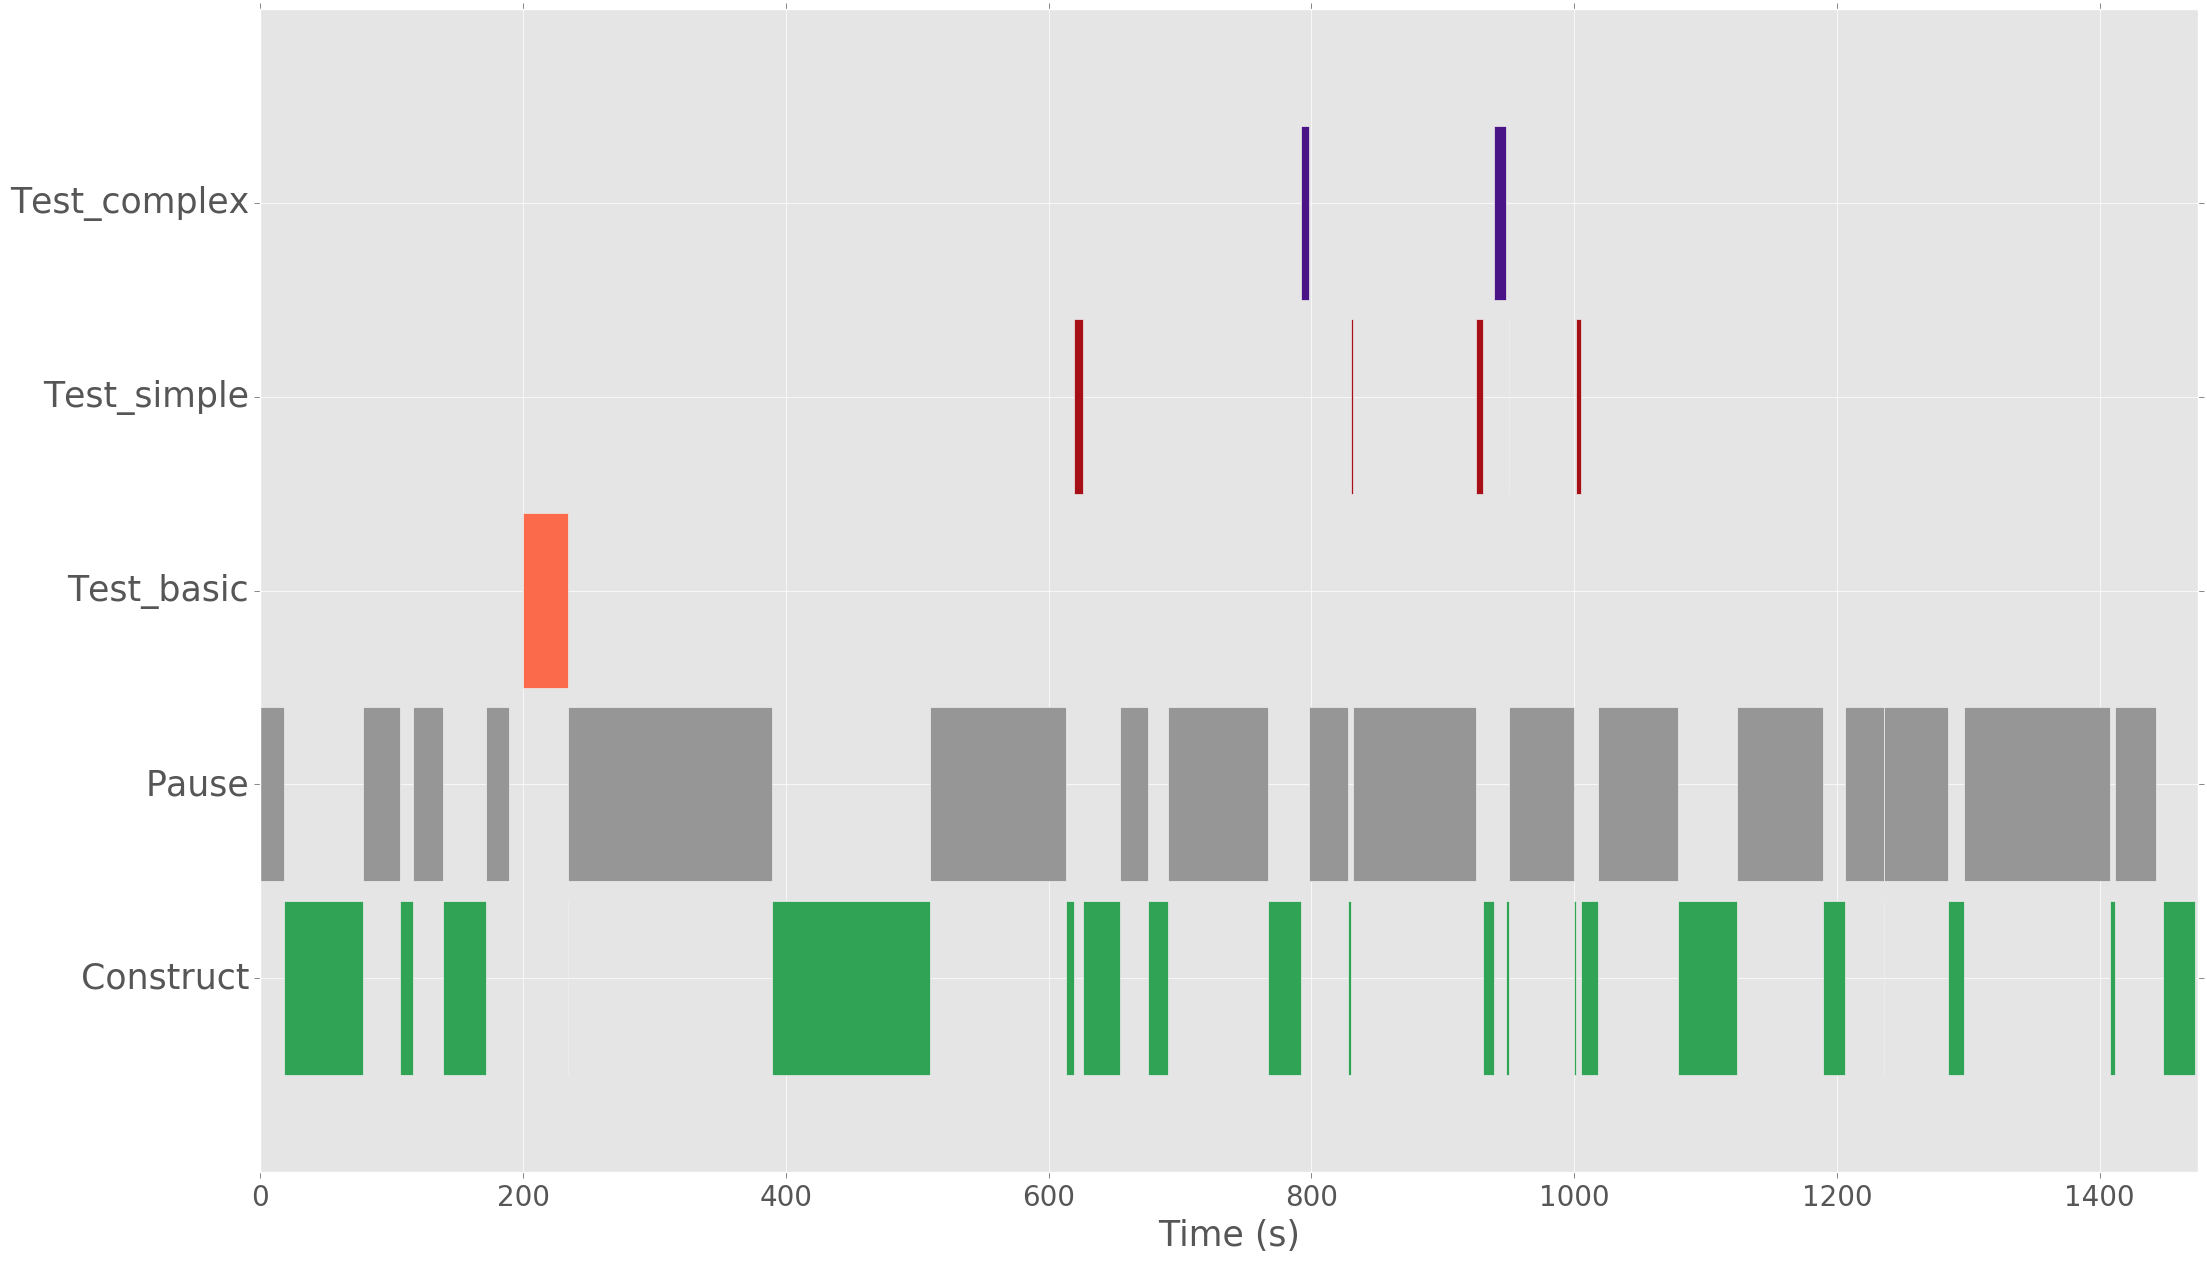

In [28]:
plot_barGraph_new(dfx,'a2',19930112, axis_labels, axis_labels) #low low z-scores

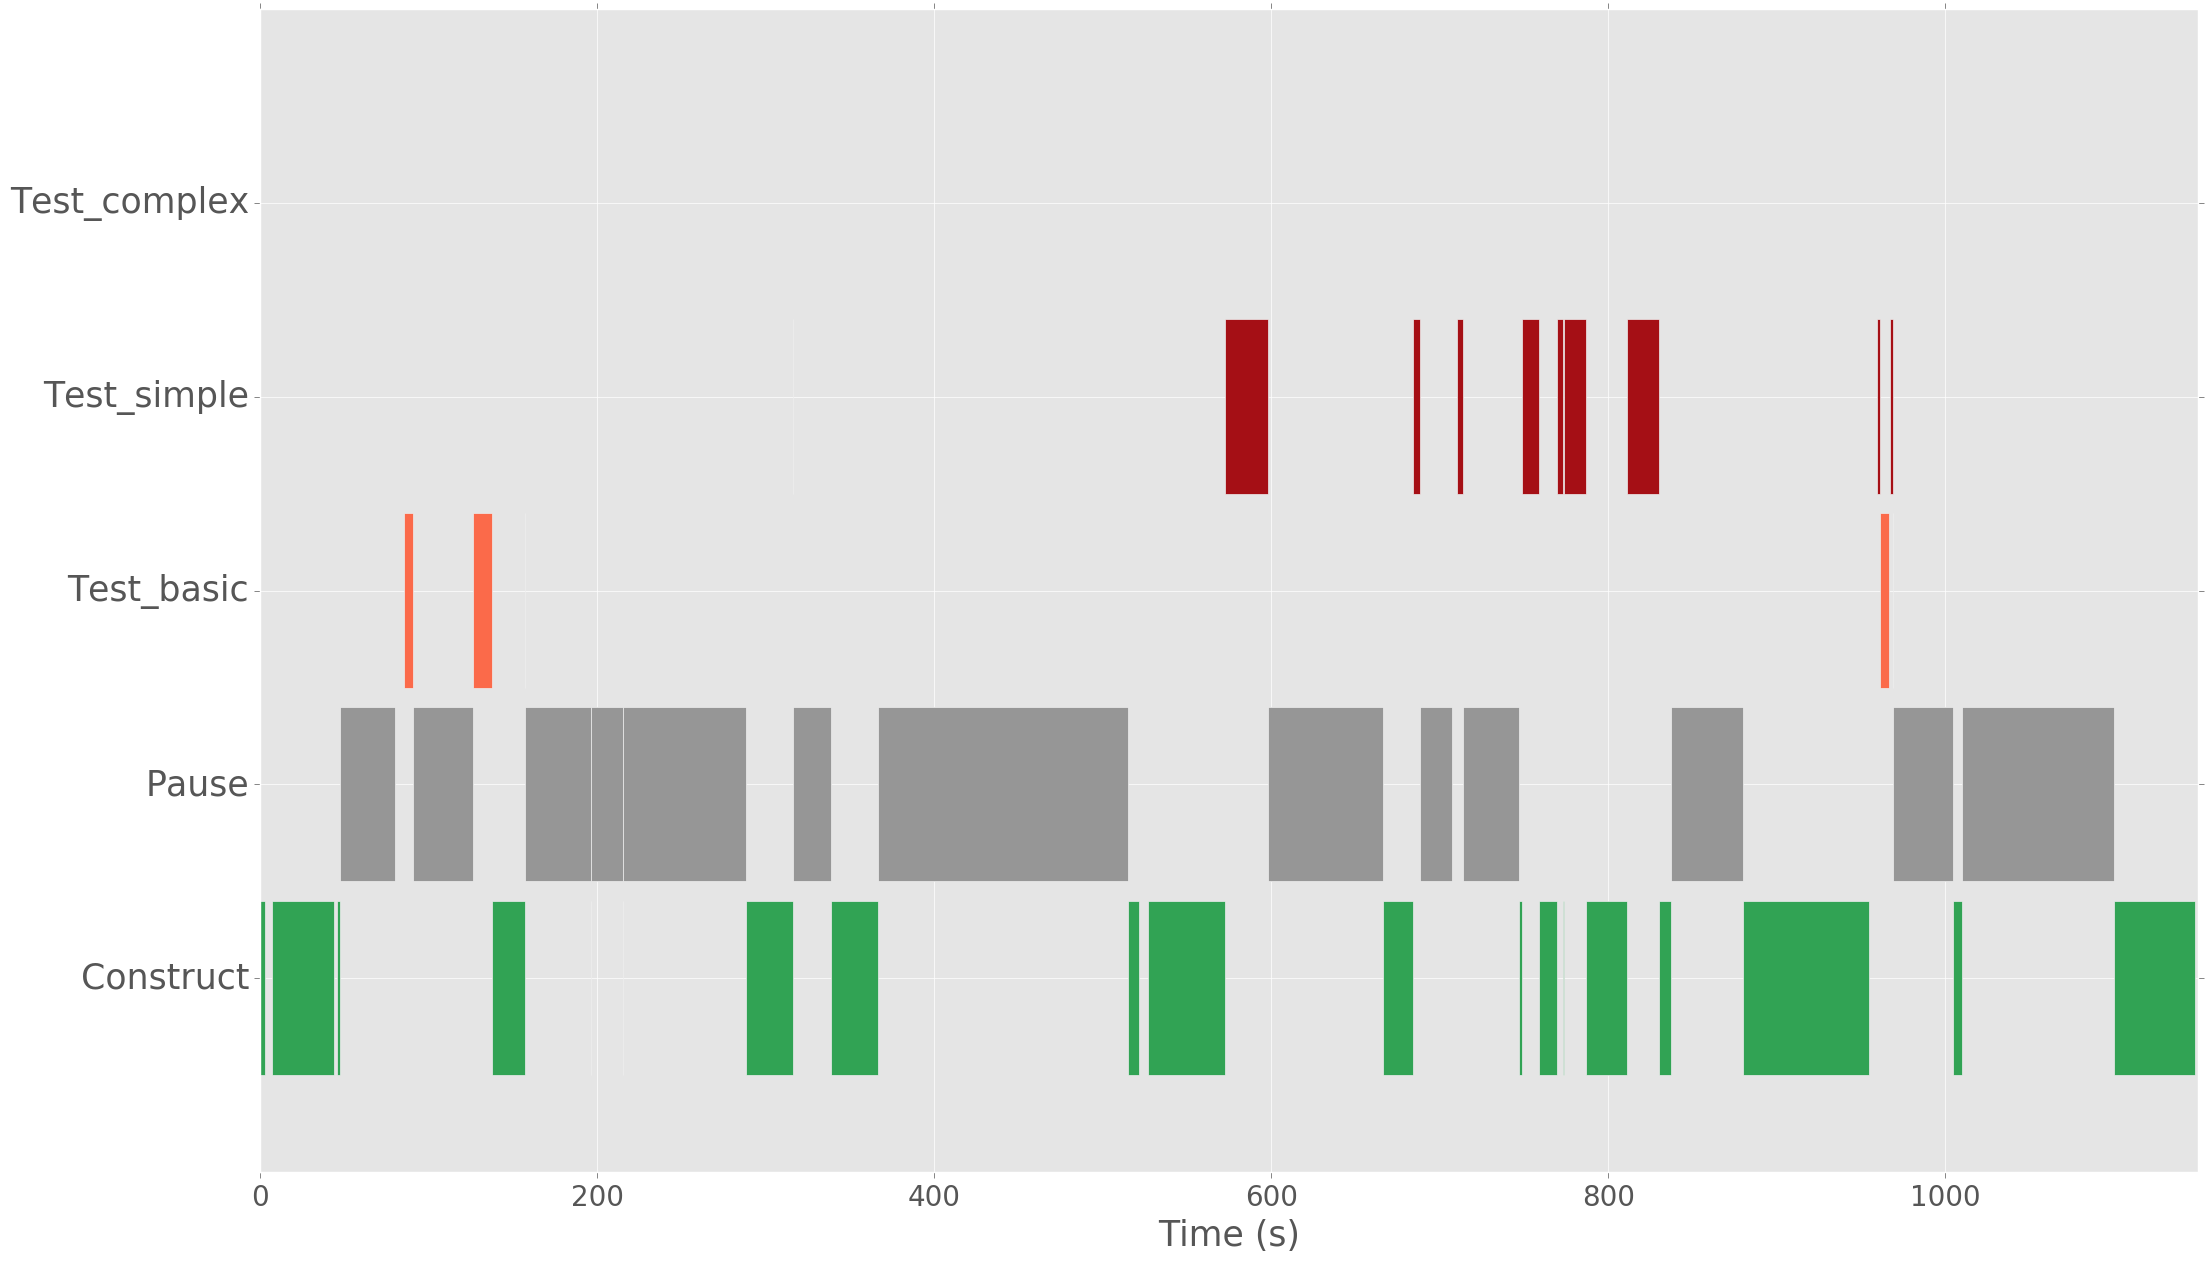

In [31]:
plot_barGraph_new(dfx,'a2', 31091114, axis_labels,axis_labels)  #high low z-scores

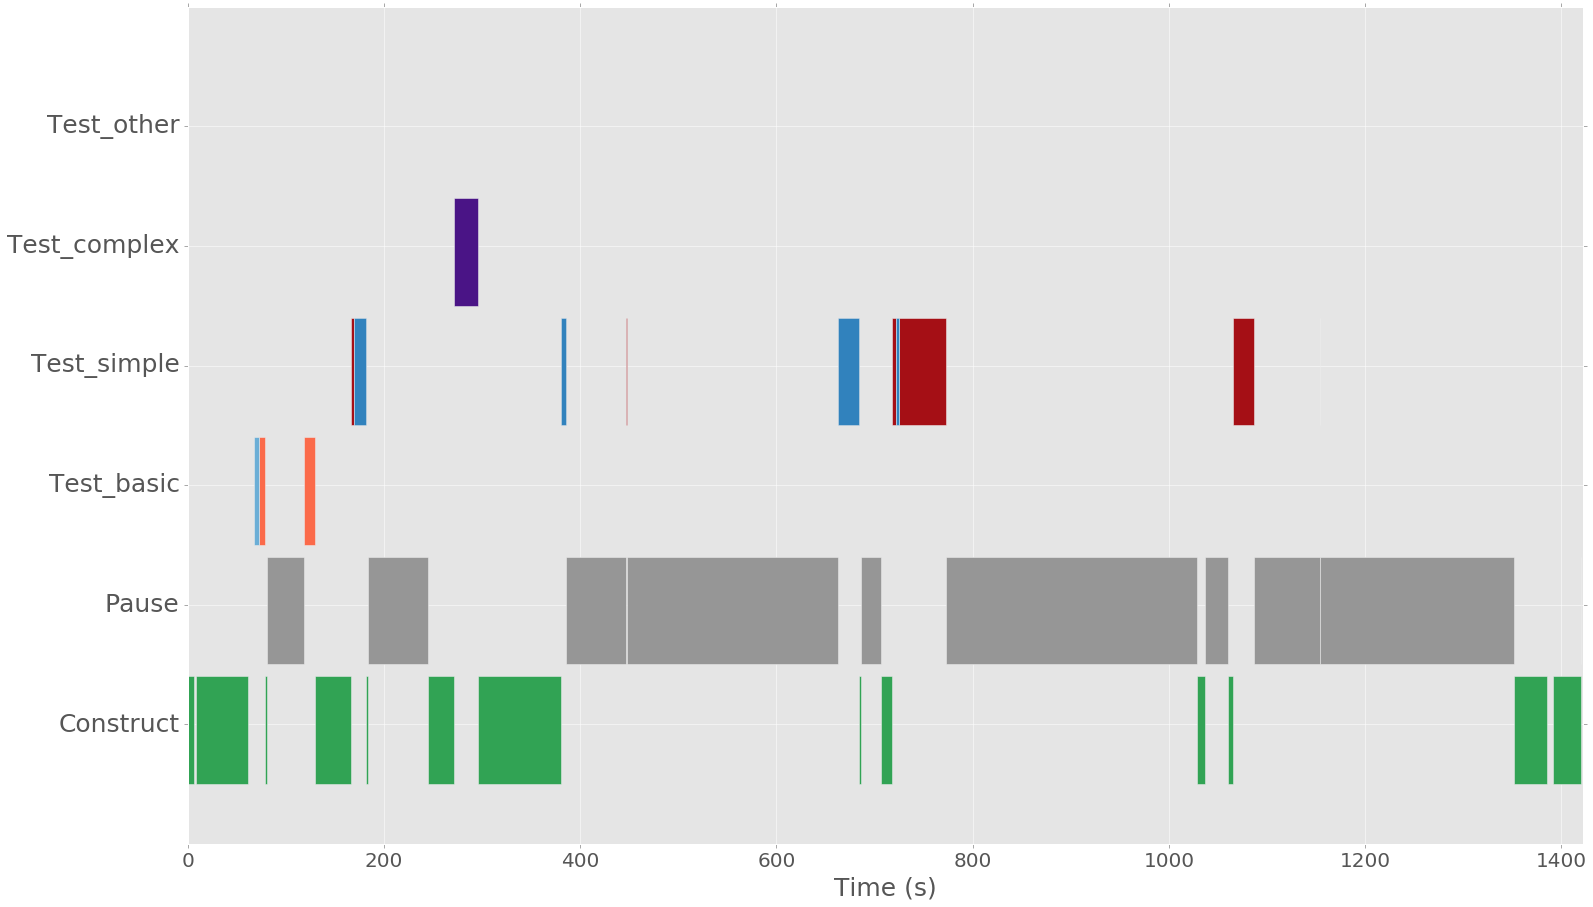

In [100]:
plot_barGraph_new(dfx,'a2', 86170104, pltFamilies_new,axis_labels)  #high low z-scores

## Plot broken bar plots for both activities and different archtypical students

In [38]:
#creating new columns in df_scores to find interesting cases to look at
df_scores["learning diff a2"]=df_scores["z post t2"]-df_scores["z pre"]
df_scores["learning gains a2"]=(df_scores["post t2"]-df_scores["pre"])/df_scores["pre"]
df_scores.sort_values("learning diff a2")

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
32,July,not,3,2,1,1,0,1,1,1,1,0.75,0.73,0.38,0.50,-0.52,1.64,0.73,-1.07,2.44,1.89,2.78,4.0,2.25,knowledge,notscaffolded_knowledge,31091114,-1447878640,-2.71,-0.49
93,March,not,3,2,1,1,0,0,0,1,1,0.75,-1.68,0.48,0.58,-0.16,1.64,-1.68,-0.52,2.33,2.00,2.33,3.5,3.00,knowledge,notscaffolded_knowledge,94186123,399993022,-2.16,-0.36
19,July,not,3,4,0,0,1,1,1,0,0,0.88,0.73,0.67,0.71,0.38,2.37,0.73,0.48,2.67,3.00,3.00,4.0,3.25,knowledge,notscaffolded_knowledge,17580122,-1717135106,-1.89,-0.24
13,July,scaff,1,2,0,0,0,1,1,2,1,0.75,1.56,0.55,0.38,-1.07,1.64,1.56,-0.14,2.89,2.89,3.00,4.0,3.25,knowledge,scaffolded_knowledge,13205111,1170221006,-1.78,-0.27
58,March,scaff,0,1,0,0,1,0,1,2,1,0.50,0.08,0.28,0.25,-1.61,0.19,0.08,-1.58,2.67,2.56,2.78,4.5,2.25,knowledge,scaffolded_knowledge,62935112,-1255076381,-1.77,-0.44
75,March,not,2,3,0,1,0,1,1,1,1,0.71,0.33,0.51,0.67,0.20,1.40,0.33,-0.36,2.67,2.78,2.89,2.0,3.00,knowledge,notscaffolded_knowledge,82224125,960603148,-1.76,-0.28
35,March,not,2,2,0,0,1,1,1,1,0,0.88,1.09,0.70,0.88,1.11,2.37,1.09,0.66,3.22,2.78,2.44,4.0,3.50,knowledge,notscaffolded_knowledge,37987123,204091780,-1.71,-0.20
69,March,scaff,2,4,0,0,0,0,1,0,0,0.50,-0.42,0.30,0.13,-2.15,0.19,-0.42,-1.49,3.67,3.67,4.00,4.0,4.00,attitude,scaffolded_attitude,70209120,238592975,-1.68,-0.40
3,March,scaff,2,3,1,1,1,1,1,2,0,0.54,-1.42,0.35,0.42,-0.88,0.43,-1.42,-1.18,3.00,3.22,3.11,4.5,3.00,attitude,scaffolded_attitude,4762120,-450686147,-1.61,-0.35
25,July,not,1,2,0,1,1,0,1,0,0,0.50,-0.72,0.36,0.17,-1.97,0.19,-0.72,-1.14,2.78,3.11,2.78,5.0,3.00,attitude,notscaffolded_attitude,23112113,96577120,-1.33,-0.28


In [ ]:
#Define what action families to plot and in what order.
#pltFamilies=['Construct', 'Organize', 'Interface', 'Extra', 'Pause', 'Test', 'ConstructWithFeedback', 'Reset']
pltFamilies=['Construct', 'Organize', 'ConstructWithFeedback','Pause', 'Test']
pltFamilies2=['Construct','Pause', 'Test']
pltFamilies3=['ContructWithFeedback','Construct','Pause', 'Test']

## Resistor activity

### Low to high scores

In [33]:
df_scores[df_scores["student"]==86170104]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
85,July,not,3,3,0,0,1,1,1,0,0,0.38,0.94,0.88,0.75,0.57,-0.54,0.94,1.59,2.11,2.33,2.44,3.5,2.75,attitude,notscaffolded_attitude,86170104,-1519298477


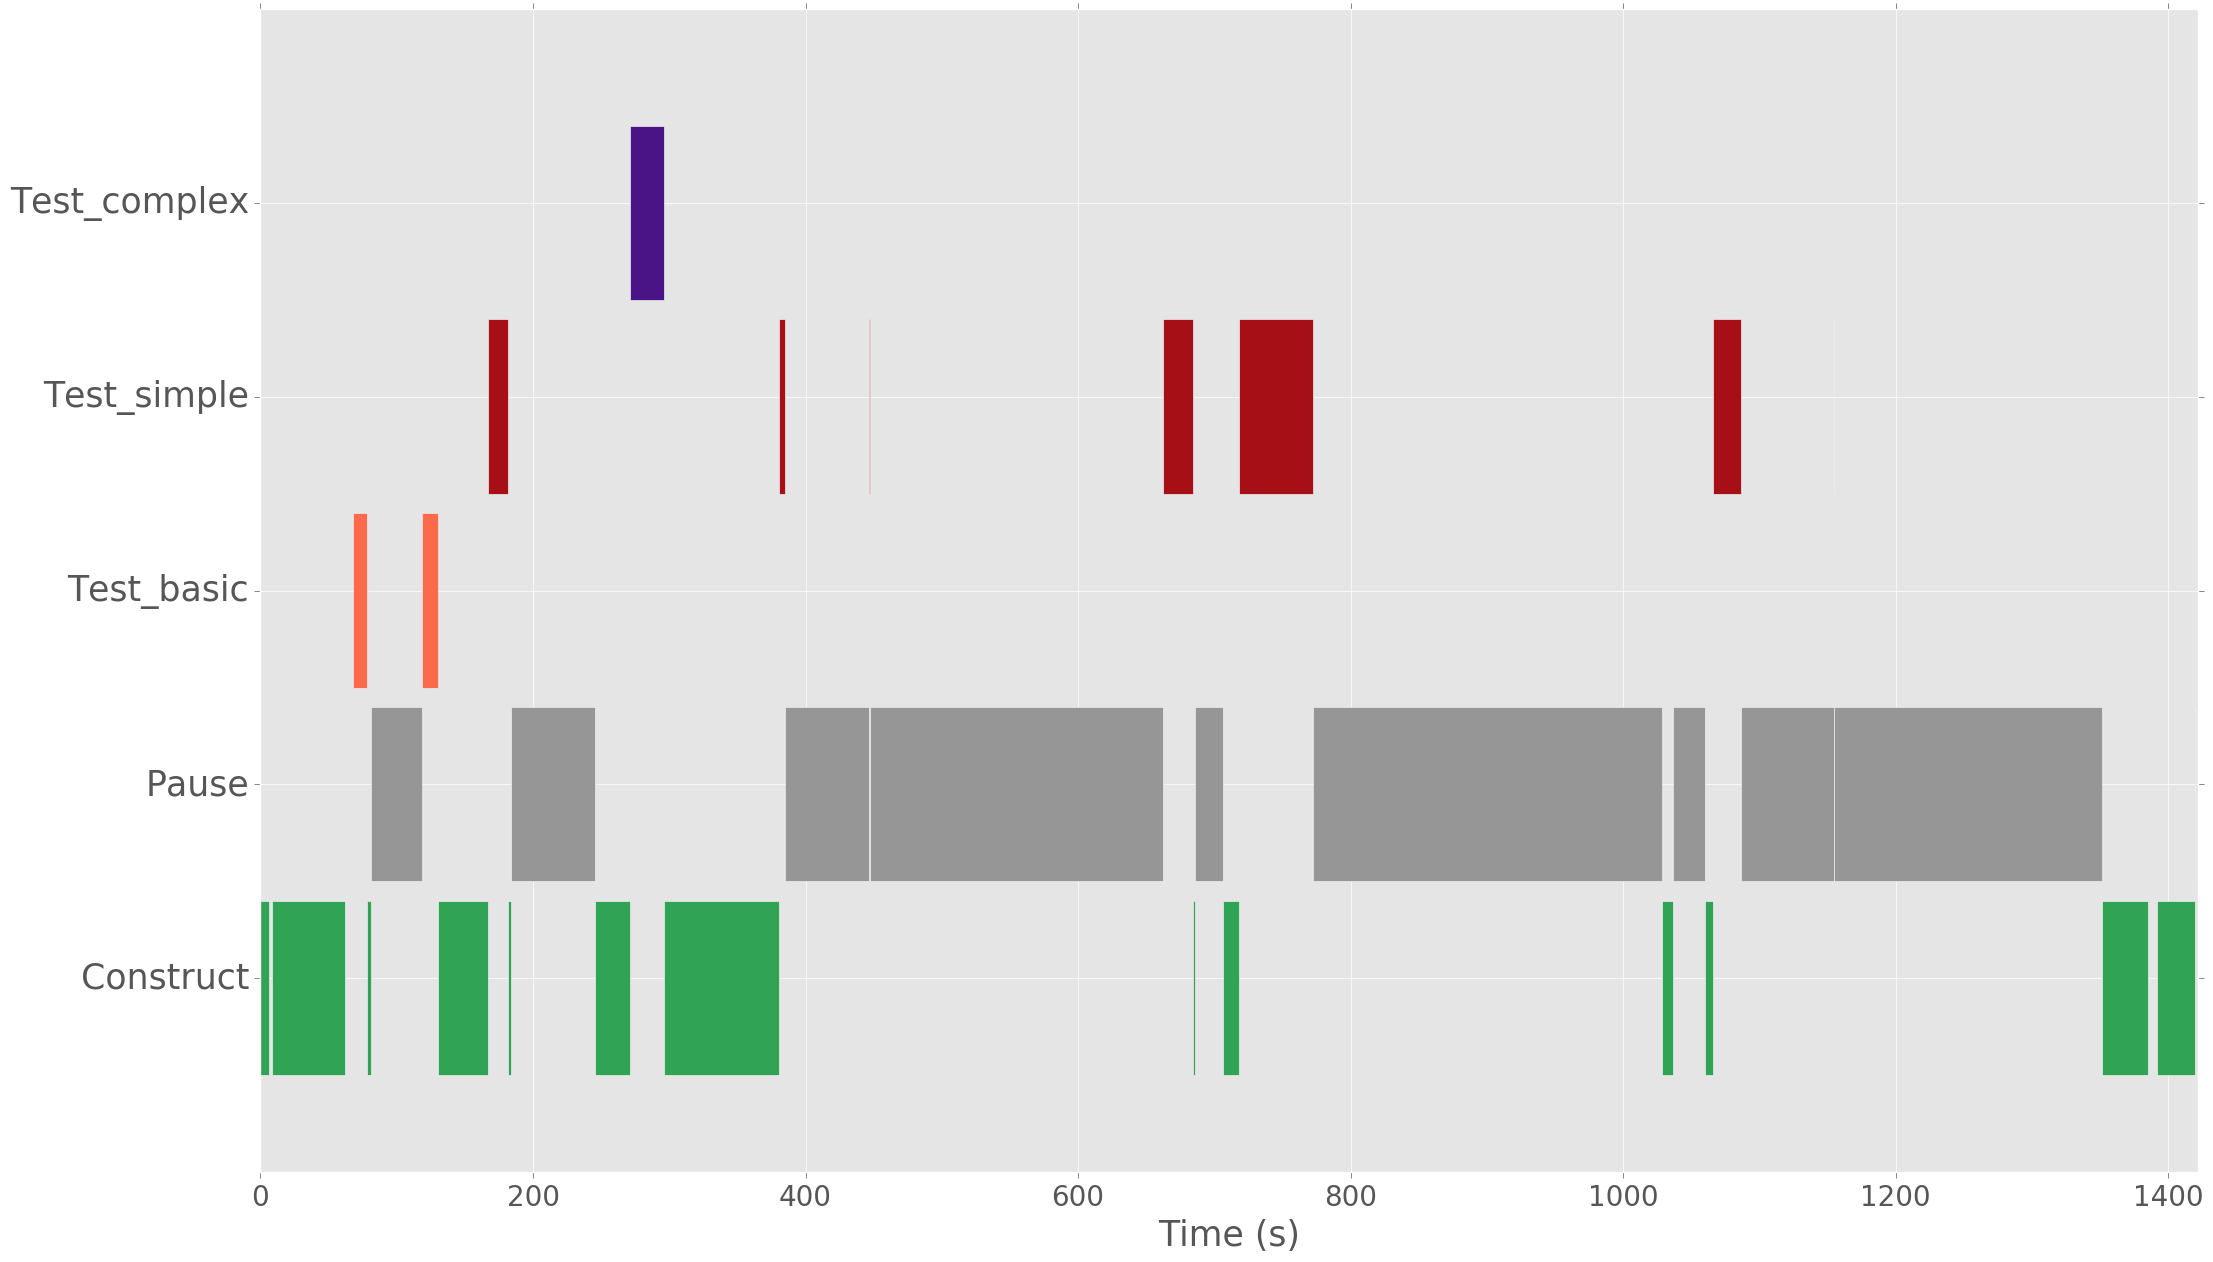

In [34]:
plot_barGraph_new(dfx,'a2', 86170104, axis_labels, axis_labels)  #low to high z-scores

In [35]:
df_scores[df_scores["student"]==1075123]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id
0,March,scaff,2,2,0,0,1,1,1,0,0,0.21,-0.42,0.64,0.79,0.75,-1.52,-0.42,0.33,2.67,2.78,2.67,4.0,3.5,attitude,scaffolded_attitude,1075123,1920143974


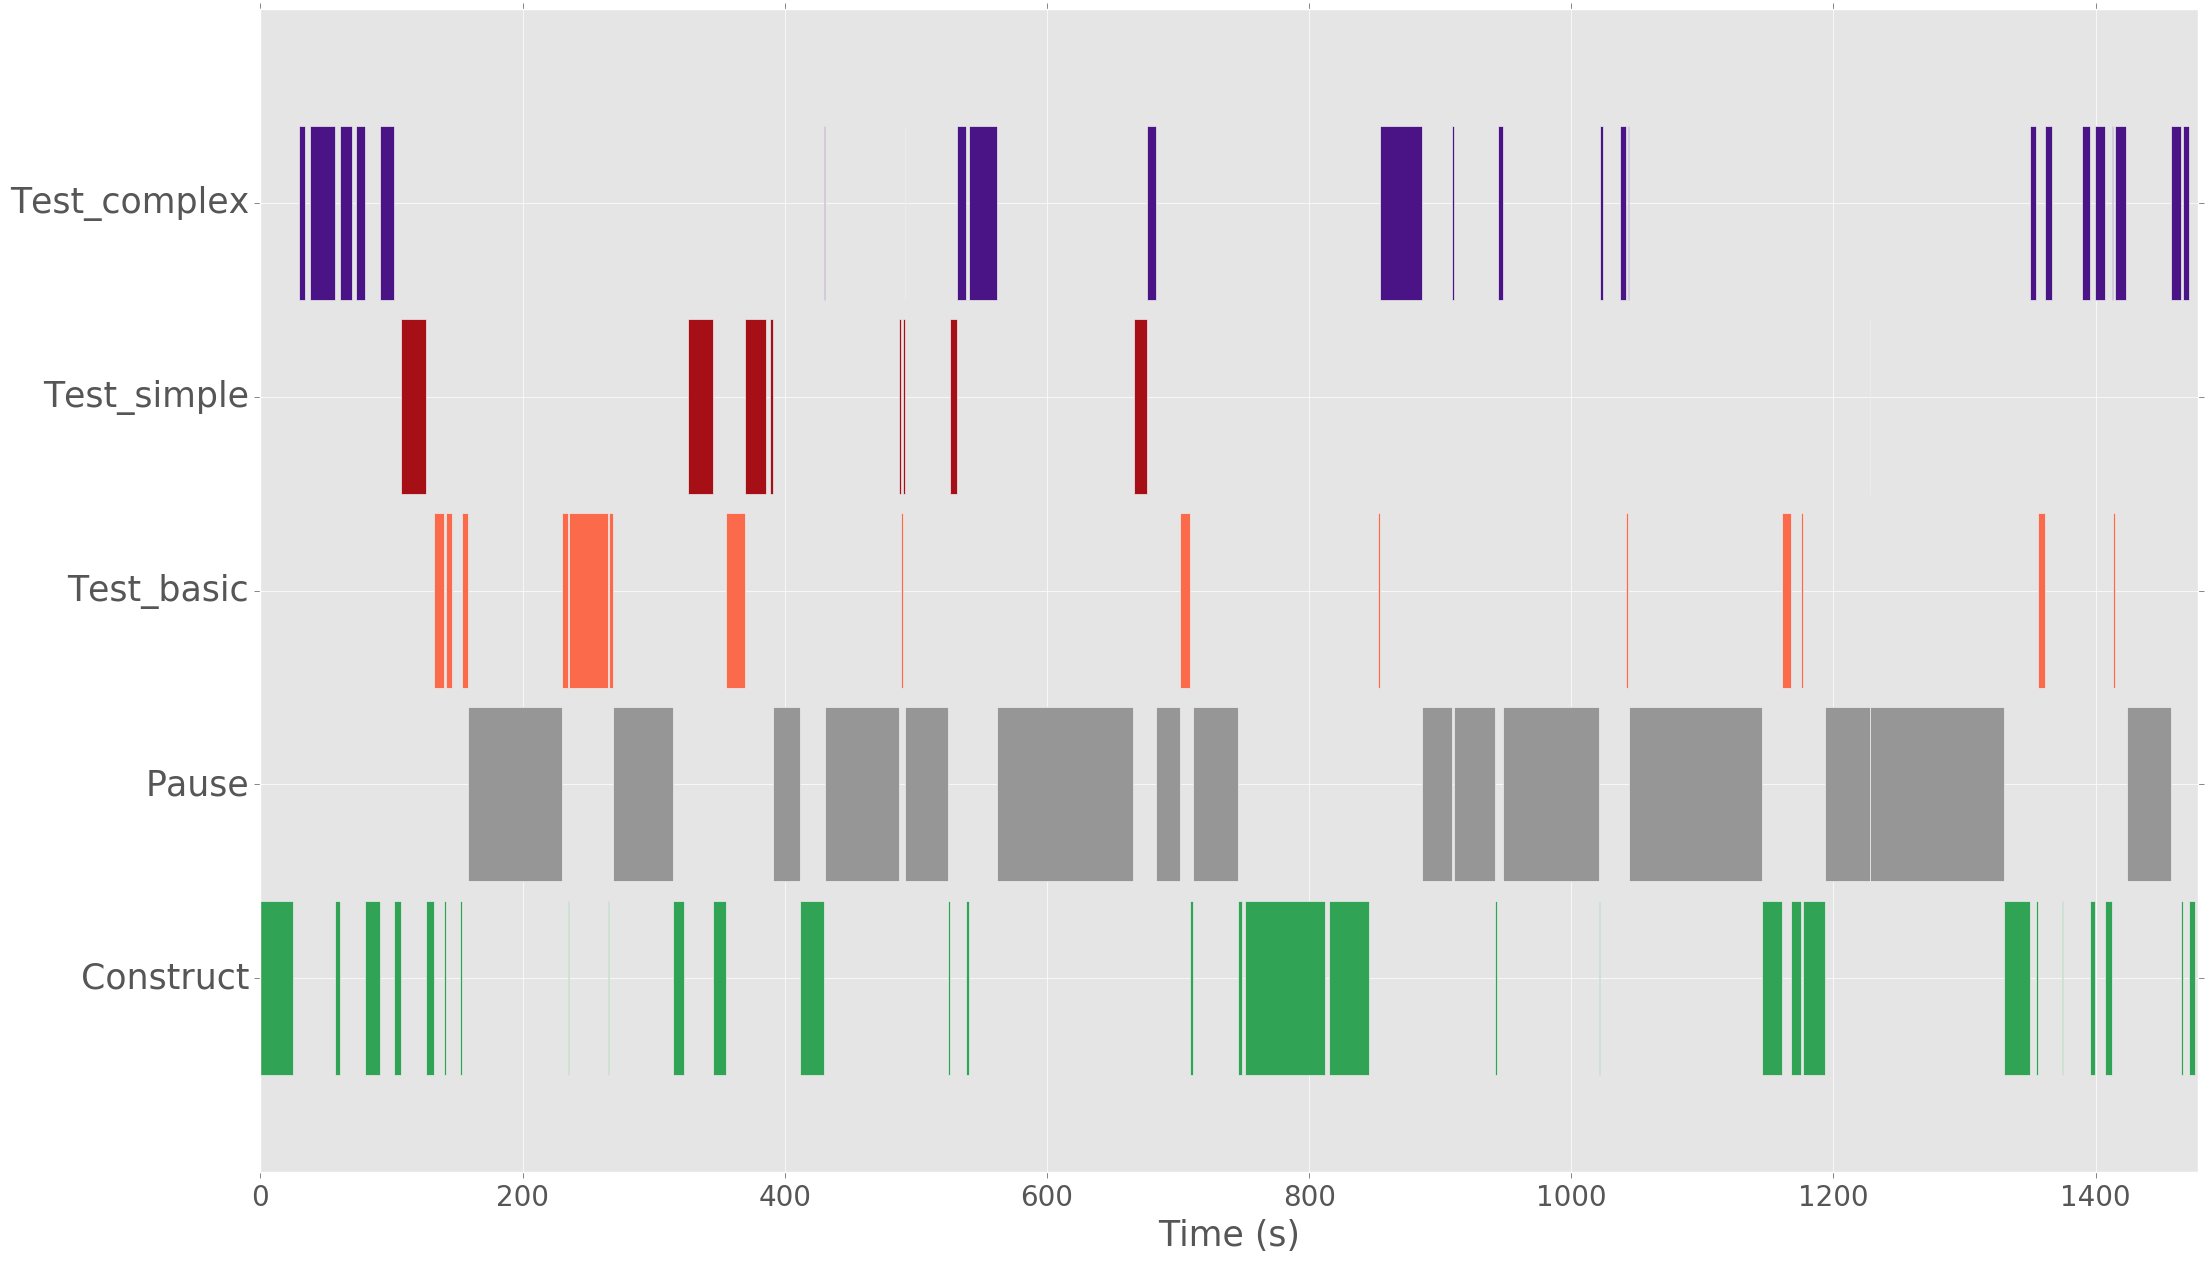

In [36]:
plot_barGraph_new(dfx,'a2', 1075123, axis_labels, axis_labels)  #another low to high z-scores

In [39]:
df_scores[df_scores["student"]==96314111]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
95,March,not,3,2,1,1,1,1,1,1,1,0.0,0.84,0.89,1.0,1.65,-2.73,0.84,1.66,2.67,3.0,2.89,4.0,3.25,attitude,notscaffolded_attitude,96314111,2030580754,4.39,inf


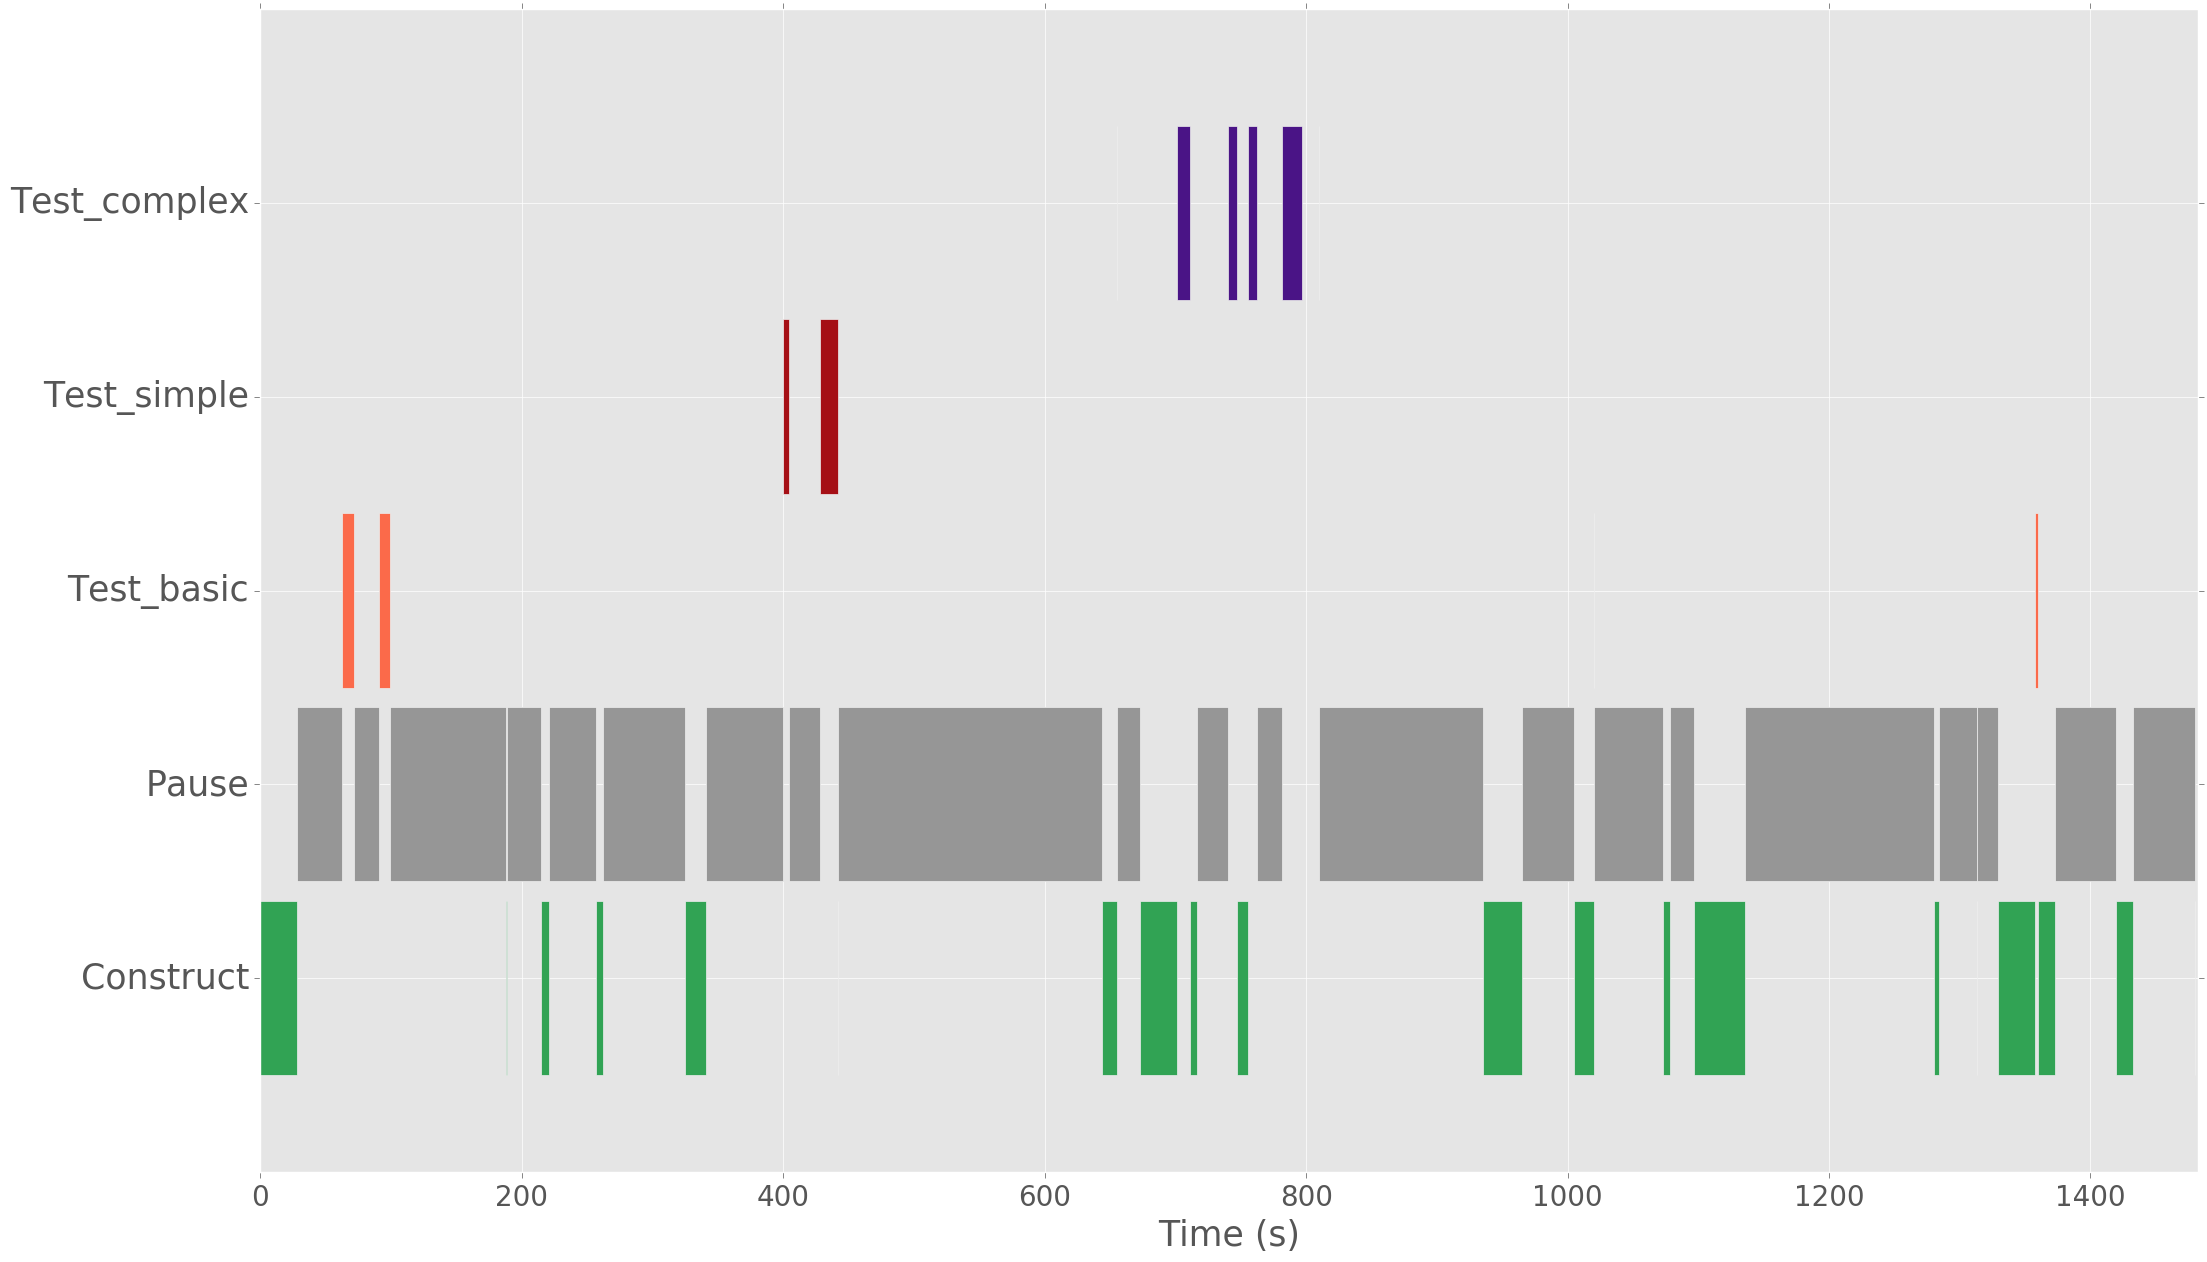

In [40]:
plot_barGraph_new(dfx,'a2', 96314111, axis_labels, axis_labels)  #another low to high z-scores

In [41]:
df_scores[df_scores["student"]==83841128]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
81,March,not,2,2,1,1,0,1,1,2,1,0.21,1.34,0.77,0.92,1.29,-1.52,1.34,1.03,2.44,2.0,2.11,4.0,2.5,attitude,notscaffolded_attitude,83841128,1733023399,2.55,2.67


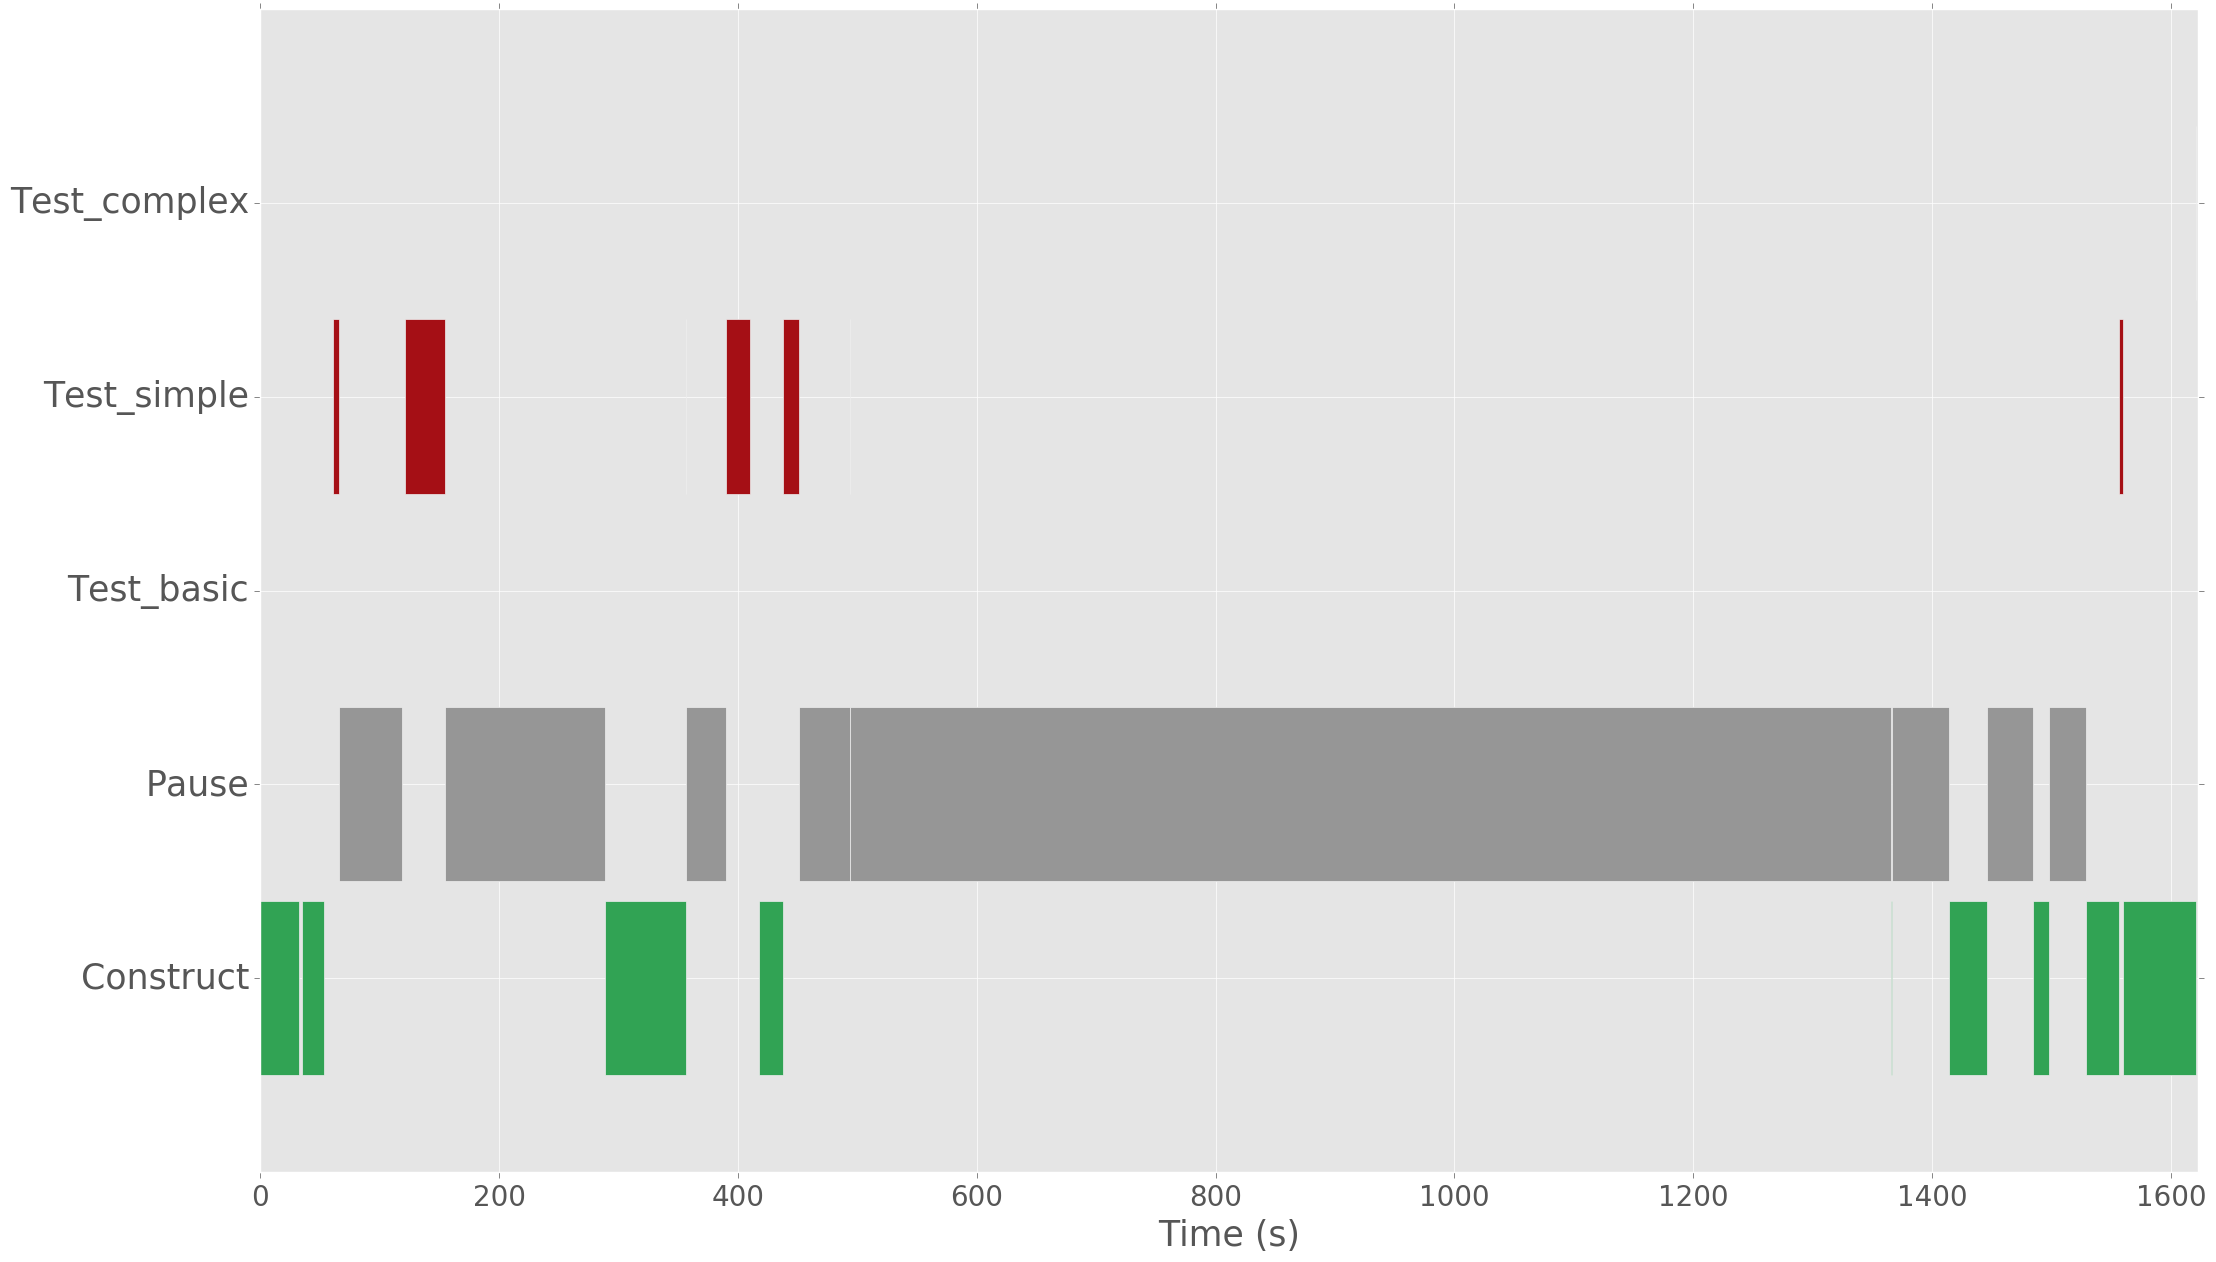

In [42]:
plot_barGraph_new(dfx,'a2', 83841128, axis_labels, axis_labels)  #another low to high z-scores

In [43]:
df_scores[df_scores["student"]==42175126]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
41,July,scaff,2,2,0,0,1,0,1,0,0,0.29,-0.09,0.69,0.75,0.57,-1.03,-0.09,0.59,2.33,2.89,2.22,4.0,3.25,attitude,scaffolded_attitude,42175126,1058332740,1.62,1.38


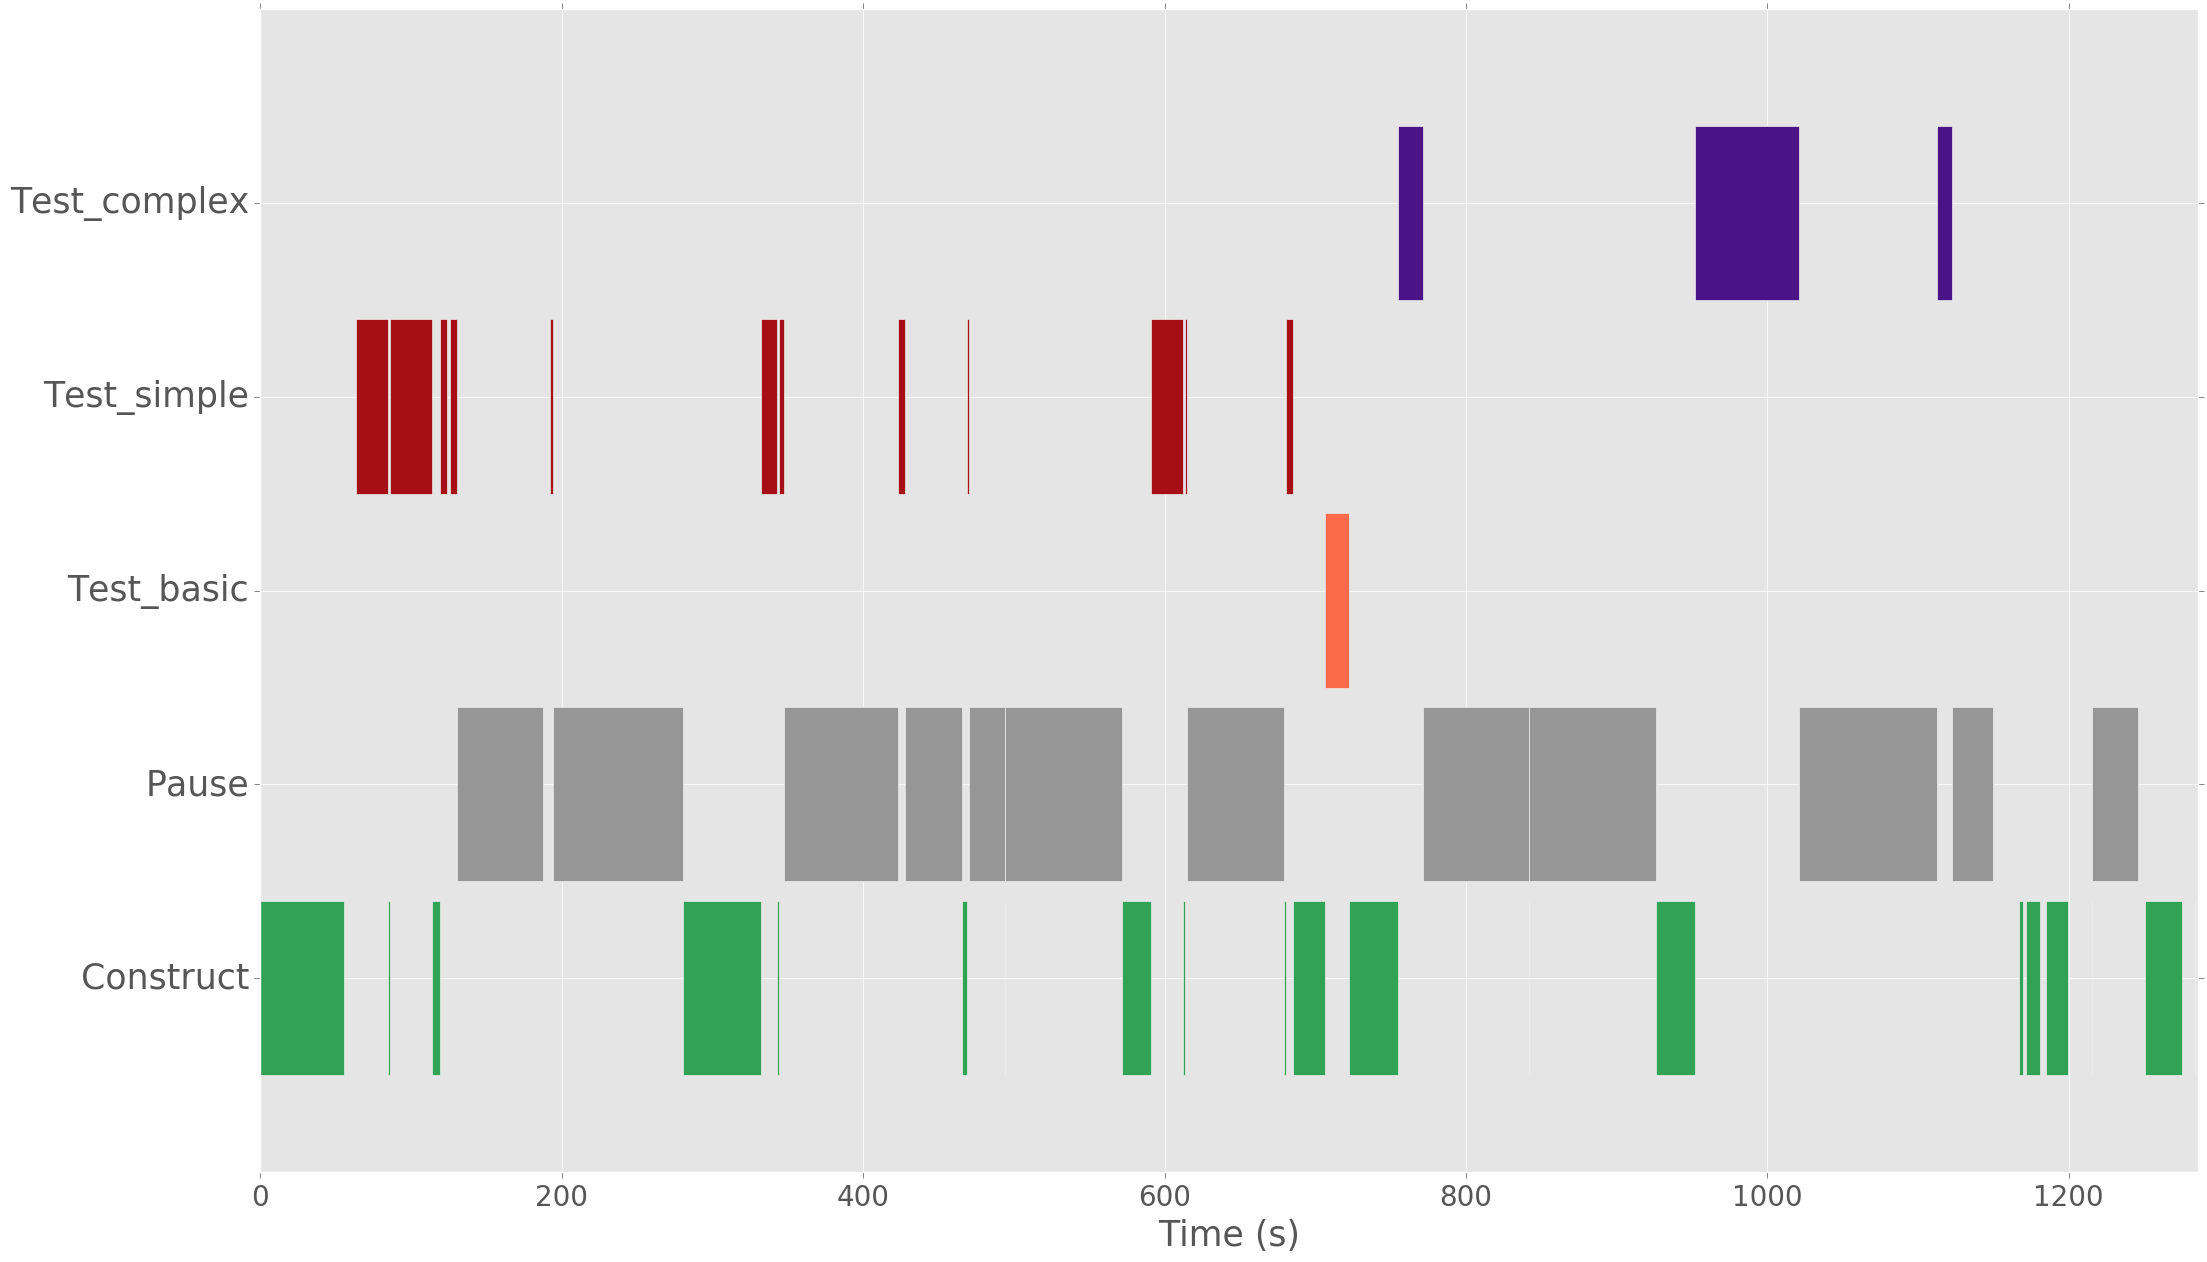

In [44]:
plot_barGraph_new(dfx,'a2', 42175126, axis_labels, axis_labels)  #another low to high z-scores

### High to low scores

In [ ]:
df_scores[df_scores["student"]==31091114]  #high learning gains (low to high z-scores)

In [ ]:
plot_barGraph(df,'a2',31091114, pltFamilies) #high low z-scores

In [ ]:
df_scores[df_scores["student"]==13205111]

In [ ]:
plot_barGraph(df,'a2',13205111, pltFamilies) #high low z-scores

### Low to low scores

In [45]:
df_scores[df_scores["student"]==8889108]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
7,July,scaff,1,3,0,0,1,1,1,0,0,0.21,-0.72,0.27,0.21,-1.79,-1.52,-0.72,-1.62,2.67,2.33,2.33,2.0,3.25,attitude,scaffolded_attitude,8889108,1140619053,-0.1,0.29


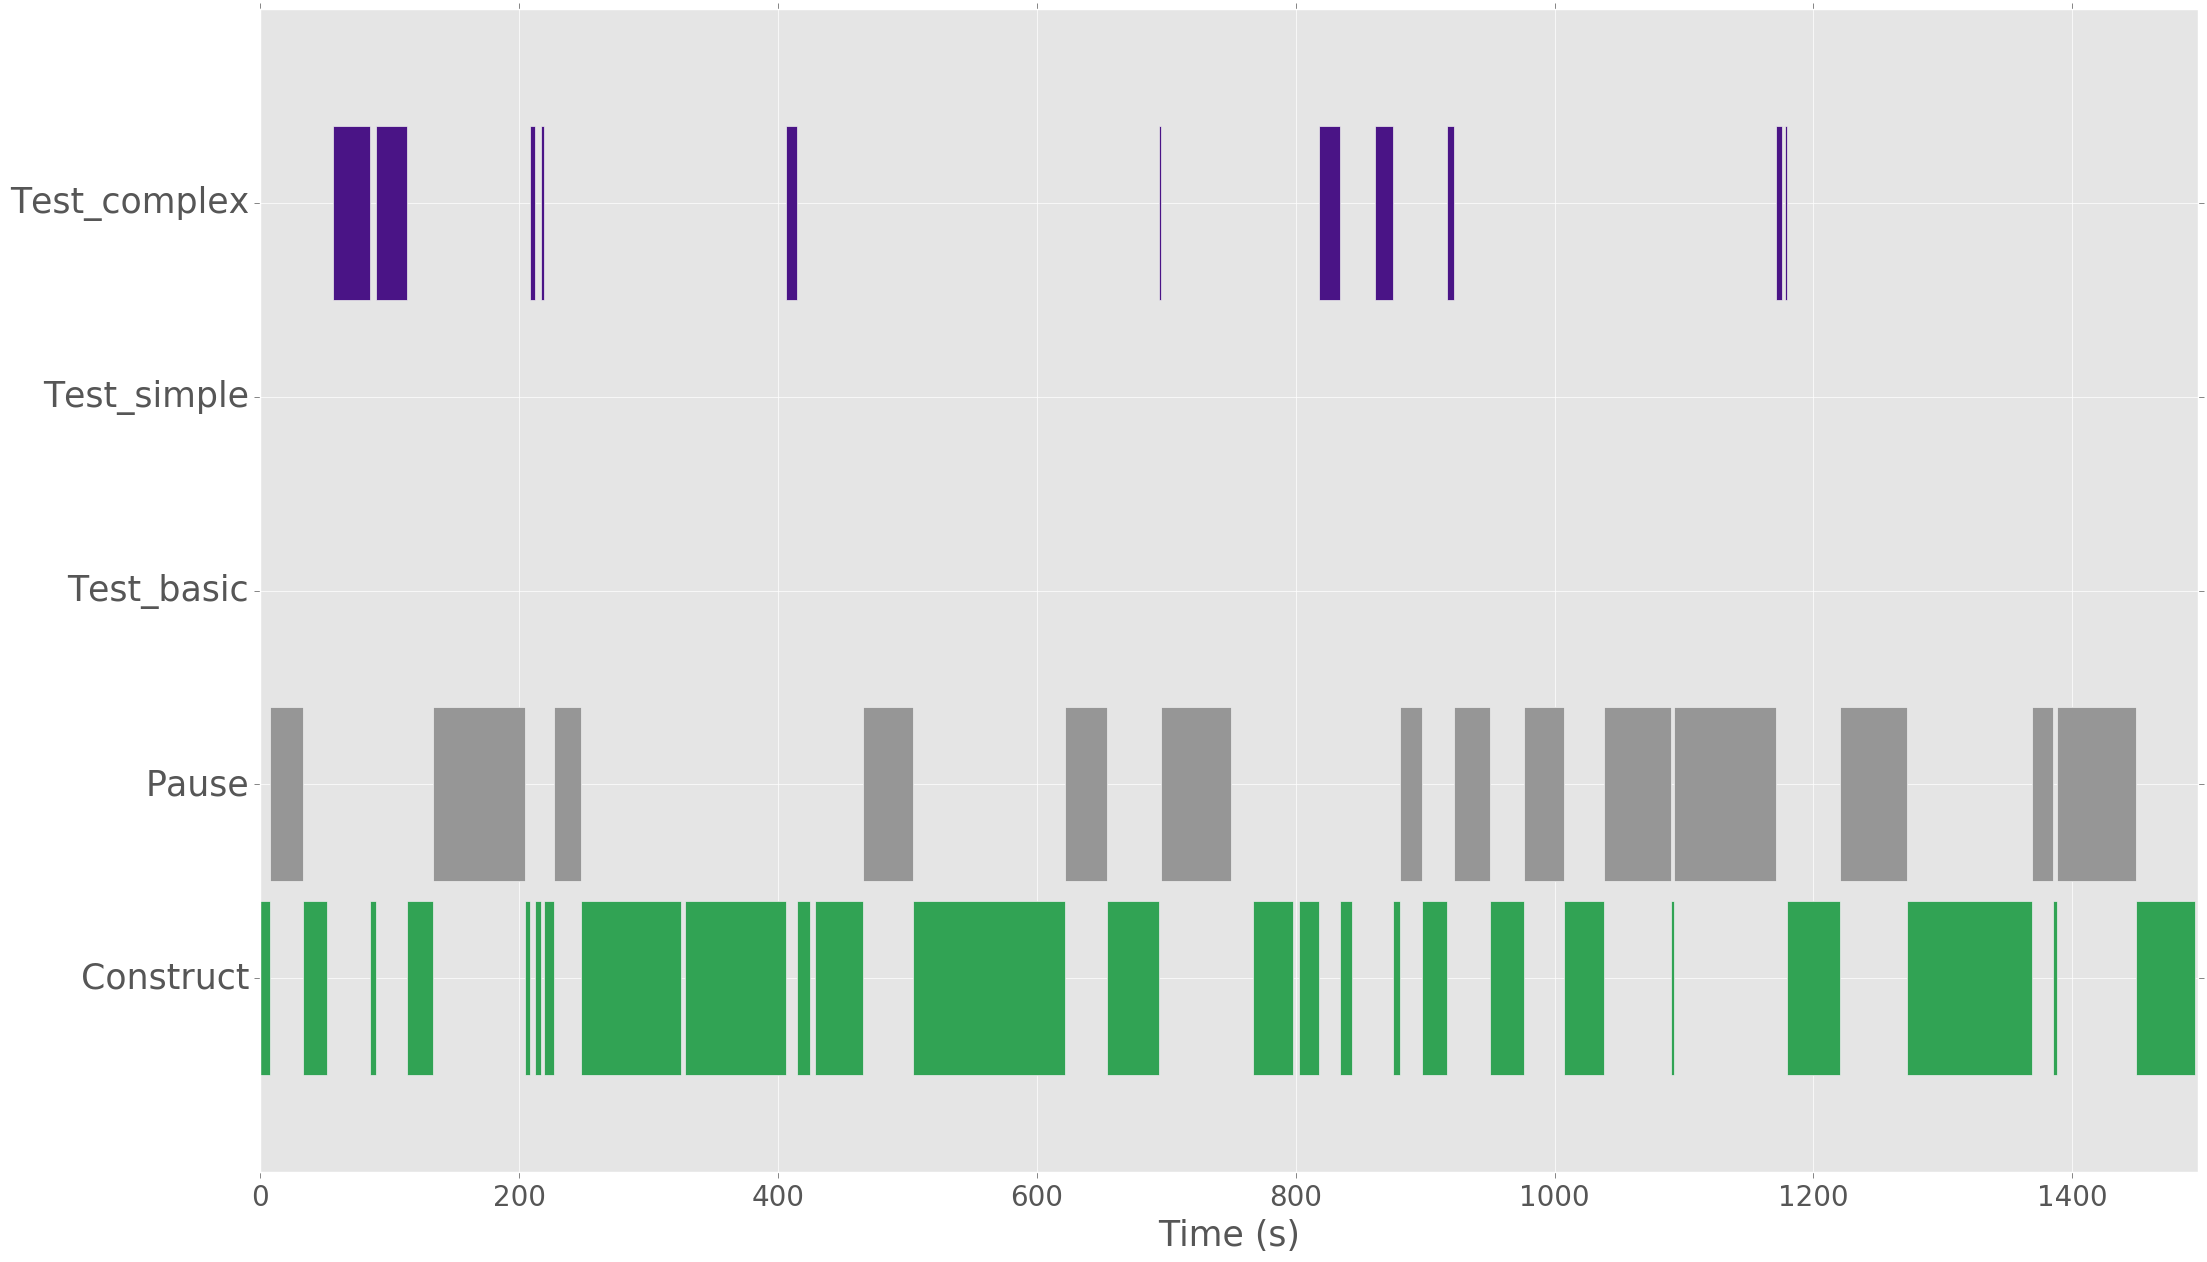

In [46]:
plot_barGraph_new(dfx,'a2', 8889108, axis_labels, axis_labels)  #low low z-scores

In [47]:
df_scores[df_scores["student"]==19930112]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
23,July,not,2,2,1,0,1,0,1,0,0,0.25,0.11,0.35,0.71,0.38,-1.27,0.11,-1.18,3.0,3.11,3.0,5.0,3.25,attitude,notscaffolded_attitude,19930112,1049426630,0.09,0.4


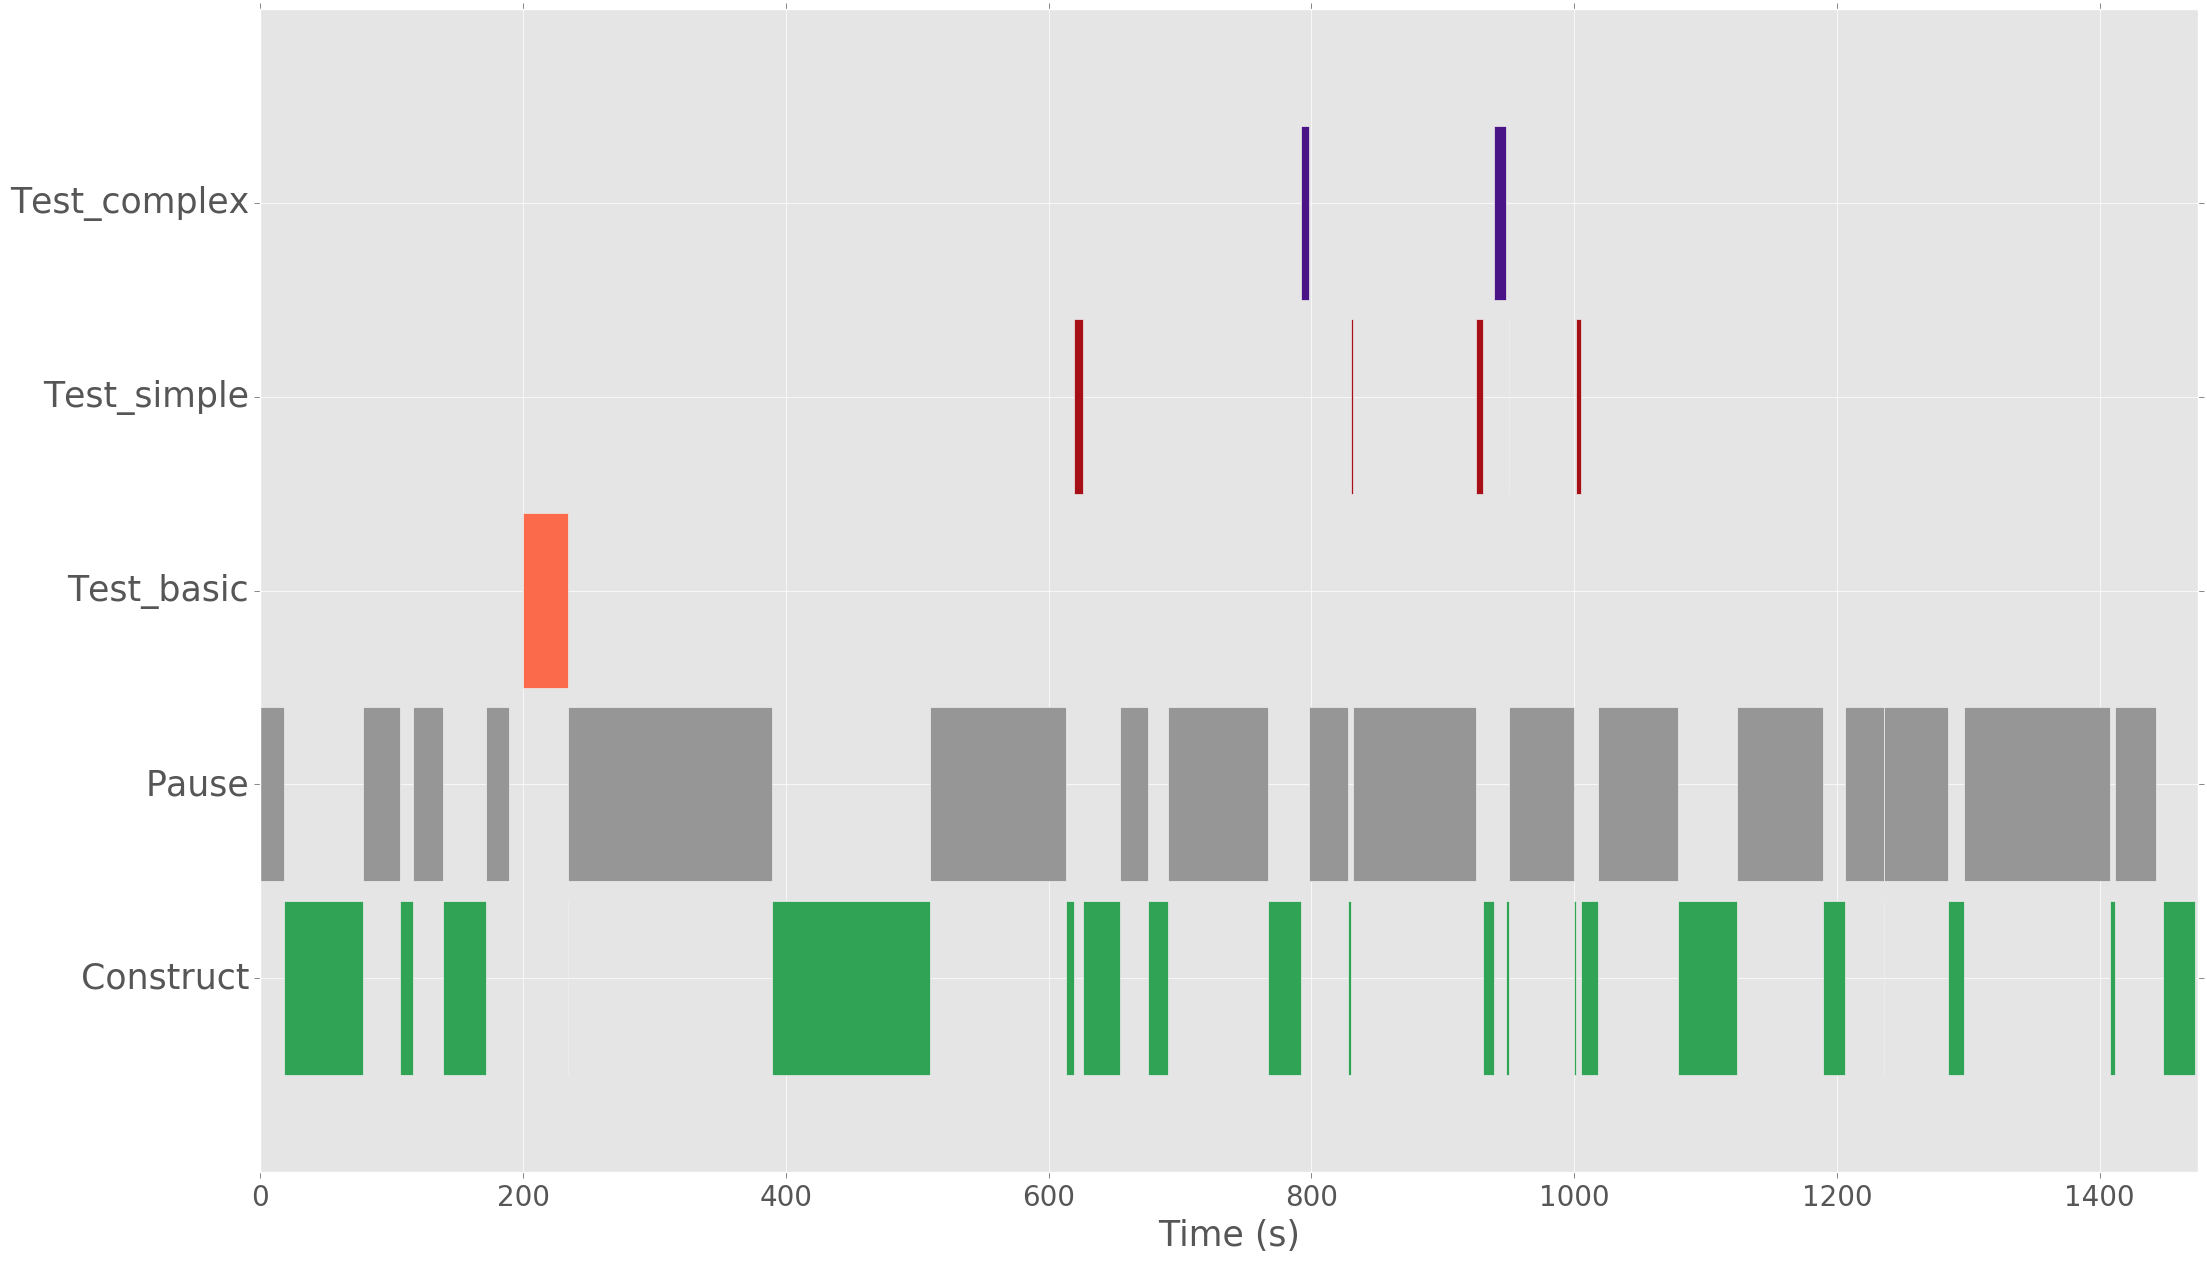

In [48]:
plot_barGraph_new(dfx,'a2', 19930112, axis_labels, axis_labels)  #low low z-scores

### High to high scores

In [ ]:
df_scores[df_scores["student"]==8580120]

In [ ]:
plot_barGraph(df,'a2',8580120, pltFamilies) #high high z-scores

In [ ]:
df_scores[df_scores["student"]==18838125]

In [ ]:
plot_barGraph(df,'a2',18838125, pltFamilies) #high high z-scores

## Plotting fewer action families: Construct = (Construct, ConstructWithFeedback, Organize)

### Low to high

In [32]:
plot_barGraph(df2,'a2', 86170104, pltFamilies2) 

NameError: name 'df2' is not defined

### High high

In [ ]:
plot_barGraph(df2,'a2',8580120, pltFamilies2) #high high z-scores

### High to low

In [ ]:
plot_barGraph(df2,'a2',31091114, pltFamilies2) #high low z-scores

### Low to low

In [ ]:
plot_barGraph(df2,'a2',8889108, pltFamilies2) #low low z-scores